In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import math
import os
import csv
from itertools import chain
from pprint import pprint
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
import statsmodels.api as sm

import statsmodels.formula.api as smf
from patsy import contrasts

### Rattle_Newton
import ThermaNewt.sim_snake_tb as therma_sim
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from sklearn.metrics import mean_squared_error


## Functions
def in_out_binary(in_out_value):
    if in_out_value=='In':
        val = 0
    else:
        val = 1
    return val

snake_name_to_id ={
    'Albert': 'EDCRVI003',
    'Cooper': 'EDCRVI004',
    'Eddie': 'EDCRVI001',
    'Hector': 'EDCRVI002',
    'Hunter': 'EDCRVI015',
    'Kokanee': 'EDCRVI013',
    'Manitoba': 'EDCRVI005',
    'Moose': 'EDCRVI006',
    'Paloma': 'EDCRVI016',
    'Victor': 'EDCRVI010',
    'Horace': 'NVCRVI037',
    'Ragnar': 'NVCRVI030',
    'Bonnie': 'MGCRVI021',
    'Caezar': 'MGCRVI015',
    'Cecilia': 'MGCRVI014',
    'Cher': 'MGCRVI013',
    'Cladwell': 'MGCRVI011',
    'Janis': 'MGCRVI010',
    'Nando': 'MGCRVI008',
    'Ringo': 'MGCRVI003',
    'Tornado': 'MGCRVI009'
}

In [2]:
impute = 'no'
if impute == 'no':
    train_fp = '../Data_Sets/raw_therma_data_2024_05_06.csv'
else:
    train_fp ='../Data_Sets/imp_therma_data_2024_05_06.csv'

train = pd.read_csv(train_fp)
train['Date'] = pd.to_datetime(train['Date'])
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['Hour'] = train['Date'].dt.hour
train['Minute'] = train['Date'].dt.minute
## Filter out Winter
overwintering = [10, 11, 12, 1, 2, 3, 4]
filter_condition = ~train['Date'].dt.month.isin(overwintering)
train = train[filter_condition]

train =train.dropna().sort_values(by=['Study_Site', 'Snake_Name', 'Date']).reset_index(drop=True)
train['Snake_Name'] = train['Snake_Name'].map(snake_name_to_id)
#train = pd.get_dummies(train, columns=['Study_Site'], prefix='Study_Site')
train.head()

,Date,Body,Study_Site,Snake_Name,Air,Burrow,Open,Shrub,Year,Month,Day,Hour,Minute
0,2022-07-07 23:00:01,25.053,Canada,EDCRVI003,19.077,18.73725,17.368,17.961667,2022,7,7,23,0
1,2022-07-08 00:10:01,25.053,Canada,EDCRVI003,19.077,18.73725,18.119,18.462333,2022,7,8,0,10
2,2022-07-08 01:20:01,25.053,Canada,EDCRVI003,18.077,18.61225,17.368,17.794667,2022,7,8,1,20
3,2022-07-08 02:30:01,24.553,Canada,EDCRVI003,16.575,17.86150,15.865,16.458667,2022,7,8,2,30
4,2022-07-08 03:40:01,24.553,Canada,EDCRVI003,15.574,16.98475,14.863,15.122333,2022,7,8,3,40


In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(14, 6))
snake_name = 'Albert'

sns.lineplot(x='Date', y='Open', data=train[train['Snake_Name']==snake_name], label='Open')

sns.lineplot(x='Date', y='Burrow', data=train[train['Snake_Name']==snake_name], label='Burrow')

sns.lineplot(x='Date', y='Body', data=train[train['Snake_Name']==snake_name], label='Snake')

sns.lineplot(x='Date', y='Air', data=train[train['Snake_Name']==snake_name], label='Air')

In [3]:
if impute == 'no':
    sim_para_fp = '../Data_Sets/ni_parameters_MMSE.csv'
else:
    sim_para_fp = '../Data_Sets/parameters_MMSE.csv'


sim_para = pd.read_csv(sim_para_fp)
sim_para['Snake_Name'] = sim_para['Snake_Name'].map(snake_name_to_id)
sim_para.head(50)

,Study_Site,Snake_Name,t_pref_min,t_pref_max,t_opt
0,Canada,EDCRVI003,18.000000,31.995966,28.028594
1,Texas-Marathon,MGCRVI021,15.754135,31.151014,20.393614
2,Texas-Marathon,MGCRVI015,10.069899,25.435778,20.654037
3,Texas-Marathon,MGCRVI014,10.755925,20.279554,20.000000
4,Texas-Marathon,MGCRVI013,17.863676,31.975117,20.406931
5,Texas-Marathon,MGCRVI011,19.965069,30.899929,21.665211
6,Canada,EDCRVI004,18.032404,32.018032,27.656736
7,Canada,EDCRVI001,17.983118,32.266383,20.862773
8,Canada,EDCRVI002,18.000000,32.000000,28.000000
9,Nebraska,NVCRVI037,18.152984,31.786573,28.150506


In [4]:
# Simulate ectotherm treating all snakes the same
k=0.01 
t_pref_max = 32 
t_pref_min = 18
t_opt = 28
t_initial=25
if impute == 'no':
    delta_t = 70
else:
    delta_t = 15


def sim_random(k, t_initial, t_pref_min, t_pref_max, t_opt, delta_t):
    simulated_t_body = []
    burrow_usage = []


    snake_names = train['Snake_Name'].unique()

    for snake in snake_names:
        condition1 = train['Snake_Name']==snake
        temp_df = train.loc[condition1]
        time=0
        t_initial=list(temp_df['Body'])[0]

        ts = therma_sim.ThermalSimulator(flip_logic='random',
                                     t_pref_min=t_pref_min,
                                     t_pref_max=t_pref_max,
                                     t_pref_opt=t_opt,seed=42)
        ss_burrow_usage, tb_sim = ts.tb_simulator_2_state_model_wrapper(
                                k=k,
                                t_initial=t_initial,
                                delta_t=delta_t,
                                burrow_temp_vector=temp_df['Burrow'],
                                open_temp_vector=temp_df['Open'],
                                return_tbody_sim=True)
        burrow_usage.append(ss_burrow_usage)
        simulated_t_body.append(tb_sim)

    burrow_usage = list(chain.from_iterable(burrow_usage))
    simulated_t_body = list(chain.from_iterable(simulated_t_body))

    train['Burrow_Usage_random'] = burrow_usage
    train['tb_sim_random'] = simulated_t_body
    train['Burrow_Usage_random'] = [in_out_binary(i) for i in train['Burrow_Usage_random']]    
    
def sim_boundary(k, t_initial, t_pref_min, t_pref_max, t_opt, delta_t):
    simulated_t_body = []
    burrow_usage = []


    snake_names = train['Snake_Name'].unique()

    for snake in snake_names:
        condition1 = train['Snake_Name']==snake
        temp_df = train.loc[condition1]
        time=0
        t_initial=list(temp_df['Body'])[0]

        ts = therma_sim.ThermalSimulator(flip_logic='boundary',
                                     t_pref_min=t_pref_min,
                                     t_pref_max=t_pref_max,
                                     t_pref_opt=t_opt,seed=42)
        ss_burrow_usage, tb_sim = ts.tb_simulator_2_state_model_wrapper(
                                k=k,
                                t_initial=t_initial,
                                delta_t=delta_t,
                                burrow_temp_vector=temp_df['Burrow'],
                                open_temp_vector=temp_df['Open'],
                                return_tbody_sim=True)
        burrow_usage.append(ss_burrow_usage)
        simulated_t_body.append(tb_sim)

    burrow_usage = list(chain.from_iterable(burrow_usage))
    simulated_t_body = list(chain.from_iterable(simulated_t_body))

    train['Burrow_Usage_boundary'] = burrow_usage
    train['tb_sim_bound'] = simulated_t_body
    train['Burrow_Usage_bound'] = [in_out_binary(i) for i in train['Burrow_Usage_boundary']]

def sim_np(k, t_initial, t_pref_min, t_pref_max, t_opt, delta_t):
    simulated_t_body = []
    burrow_usage = []


    snake_names = train['Snake_Name'].unique()

    for snake in snake_names:
        condition1 = train['Snake_Name']==snake
        temp_df = train.loc[condition1]
        time=0
        t_initial=list(temp_df['Body'])[0]

        ts = therma_sim.ThermalSimulator(flip_logic='preferred',
                                     t_pref_min=t_pref_min,
                                     t_pref_max=t_pref_max,
                                     t_pref_opt=t_opt, seed=42)
        ss_burrow_usage, tb_sim = ts.tb_simulator_2_state_model_wrapper(
                                k=k,
                                t_initial=t_initial,
                                delta_t=delta_t,
                                burrow_temp_vector=temp_df['Burrow'],
                                open_temp_vector=temp_df['Open'],
                                return_tbody_sim=True)
        burrow_usage.append(ss_burrow_usage)
        simulated_t_body.append(tb_sim)

    burrow_usage = list(chain.from_iterable(burrow_usage))
    simulated_t_body = list(chain.from_iterable(simulated_t_body))

    train['Burrow_Usage_np'] = burrow_usage
    train['tb_sim_np'] = simulated_t_body
    train['Burrow_Usage_np'] = [in_out_binary(i) for i in train['Burrow_Usage_np']]
    
def sim_p(k, t_initial, delta_t):
    simulated_t_body = []
    burrow_usage = []

    snake_names = train['Snake_Name'].unique()

    for snake in snake_names:
        condition1 = train['Snake_Name']==snake
        temp_df = train.loc[condition1]
        # Get Parameters
        para_condition = sim_para['Snake_Name']==snake
        temp_para = sim_para[para_condition]
        t_pref_min = float(temp_para['t_pref_min'].iloc[0])
        t_pref_max = float(temp_para['t_pref_max'].iloc[0])
        t_opt = float(temp_para['t_opt'].iloc[0])
        #debounce = float(temp_para['debounce'].iloc[0])
        #Run Simulation
        ts = therma_sim.ThermalSimulator(flip_logic='preferred',
                                     t_pref_min=t_pref_min,
                                     t_pref_max=t_pref_max,
                                     t_pref_opt=t_opt, seed=42)
        ss_burrow_usage, tb_sim = ts.tb_simulator_2_state_model_wrapper(
                                k=k,
                                t_initial=t_initial,
                                delta_t=delta_t, 
                                burrow_temp_vector=temp_df['Burrow'],
                                open_temp_vector=temp_df['Open'],
                                return_tbody_sim=True)
        burrow_usage.append(ss_burrow_usage)
        simulated_t_body.append(tb_sim)

    burrow_usage = list(chain.from_iterable(burrow_usage))
    simulated_t_body = list(chain.from_iterable(simulated_t_body))

    train['Burrow_Usage_p'] = burrow_usage
    train['tb_sim_p'] = simulated_t_body
    train['Burrow_Usage_p'] = [in_out_binary(i) for i in train['Burrow_Usage_p']]

#### Run Sims
sim_random(k=k, t_initial=t_initial,t_pref_min=t_pref_min, t_pref_max=t_pref_max, t_opt=t_opt, delta_t=delta_t)
sim_boundary(k=k, t_initial=t_initial, t_pref_min=t_pref_min, t_pref_max=t_pref_max, t_opt=t_opt, delta_t=delta_t)
sim_np(k=k, t_initial=t_initial, t_pref_min=t_pref_min, t_pref_max=t_pref_max, t_opt=t_opt, delta_t=delta_t)
sim_p(k=k, t_initial=t_initial, delta_t=delta_t)

In [9]:
train['Burrow_Usage_np'].unique()
# len(train['Burrow_Usage_p'])
# # 57070
# val = 33035 + 21422
# print(57070-val)

array([0, 1])

In [5]:
shit_data = train[train['Burrow_Usage_np'].isna()][['Date', 'Study_Site', 'Snake_Name', 'Open', 'Burrow', 'tb_sim_np', 'Burrow_Usage_np']]  # If None is stored as NaN
#train.to_csv('output.csv')
len(shit_data)

0

In [10]:
data = []
snake_names = train['Snake_Name'].unique()
for snake in snake_names:
    condition1 = train['Snake_Name']==snake
    temp_df = train.loc[condition1]
    study_site = temp_df['Study_Site'].unique()[0]
    act_body = temp_df['Body']
    tb_sim_random = temp_df['tb_sim_random']
    tb_sim_boundary = temp_df['tb_sim_bound']
    tb_sim_np = temp_df['tb_sim_np']
    tb_sim_p = temp_df['tb_sim_p']
    
    distance_rand, path_np = fastdtw(act_body, tb_sim_random, dist=euclidean)
    distance_bd, path_np = fastdtw(act_body, tb_sim_boundary, dist=euclidean)
    distance_np, path_np = fastdtw(act_body, tb_sim_np, dist=euclidean)
    distance_p, path_p = fastdtw(act_body, tb_sim_p, dist=euclidean)

    mape_rand = np.mean(np.abs((act_body - tb_sim_random) / (act_body + np.finfo(float).eps))) * 100
    mape_bd = np.mean(np.abs((act_body - tb_sim_boundary) / (act_body + np.finfo(float).eps))) * 100
    mape_np = np.mean(np.abs((act_body - tb_sim_np) / (act_body + np.finfo(float).eps))) * 100
    mape_p = np.mean(np.abs((act_body - tb_sim_p) / (act_body + np.finfo(float).eps))) * 100

    mse_rand = mean_squared_error(act_body, tb_sim_random)
    mse_bd = mean_squared_error(act_body, tb_sim_boundary)
    mse_np = mean_squared_error(act_body, tb_sim_np)
    mse_p = mean_squared_error(act_body, tb_sim_p)
    data_i = [study_site, snake,
              distance_rand, distance_bd, distance_np, distance_p,
              mape_rand, mape_bd, mape_np, mape_p,
              mse_rand, mse_bd, mse_np, mse_p]
    data.append(data_i)
df = pd.DataFrame(data)
df.columns = ['Study_Site', 'Snake_Name','DTW_RAND', 'DTW_BD', 'DTW_NP', 'DTW_P', 
              'MAPE_RAND', 'MAPE_BD', 'MAPE_NP', 'MAPE_P',
              'MSE_RAND', 'MSE_BD', 'MSE_NP', 'MSE_P']
df.head()

,Study_Site,Snake_Name,DTW_RAND,DTW_BD,DTW_NP,DTW_P,MAPE_RAND,MAPE_BD,MAPE_NP,MAPE_P,MSE_RAND,MSE_BD,MSE_NP,MSE_P
0,Canada,EDCRVI003,10625.341742,8482.787517,7452.037193,7451.190063,21.750293,18.566787,17.759766,17.694152,38.296178,23.204844,18.516036,18.454717
1,Canada,EDCRVI004,14172.493818,12253.472698,11451.629706,11253.097339,26.112485,23.728185,21.910100,21.787393,47.074054,32.423974,25.622307,25.238513
2,Canada,EDCRVI001,12800.168906,10930.116332,12534.826463,14081.873918,30.984702,30.706079,28.159992,27.273088,49.722027,41.902830,33.836770,32.284278
3,Canada,EDCRVI002,13435.867116,12599.458313,10610.175678,10730.418627,38.577263,40.179668,36.506596,36.622562,53.440457,49.443087,38.072924,38.308551
4,Canada,EDCRVI015,13096.832527,9607.746267,8674.623129,9106.631655,27.206409,25.813555,24.293742,23.549895,43.096936,31.009065,24.932098,24.066612


In [11]:
# Melting the DataFrame for easier plotting with seaborn
df_melted_DTW = pd.melt(df, id_vars=["Study_Site","Snake_Name"], value_vars=['DTW_RAND', 'DTW_BD',"DTW_NP", "DTW_P"], var_name="Metric_Type", value_name="DTW_Value")
df_melted_mape = pd.melt(df, id_vars=["Study_Site","Snake_Name"], value_vars=['MAPE_RAND', 'MAPE_BD', "MAPE_NP", "MAPE_P"], var_name="Metric_Type", value_name="MAPE_Value")
df_melted_mse = pd.melt(df, id_vars=["Study_Site","Snake_Name"], value_vars=['MSE_RAND', 'MSE_BD',"MSE_NP", "MSE_P"], var_name="Metric_Type", value_name="MSE_Value")
# # MSE
df_melted_mse['Metric_Type'] = pd.Categorical(df_melted_mse['Metric_Type'], 
                                             categories=['MSE_RAND', 'MSE_BD', 'MSE_NP', 'MSE_P'],
                                             ordered=False)
df_melted_mse['Study_Site'] = pd.Categorical(df_melted_mse['Study_Site'], 
                                             categories=['Canada', 'Nebraska', 'Texas-Marathon'],
                                             ordered=False)

mapping_MSE = {
    'MSE_RAND': 'Random',
    'MSE_BD': 'Boundary',
    'MSE_NP': 'Preferred',
    'MSE_P': 'Preferred_est'
}
df_melted_mse['Metric_Type'] = df_melted_mse['Metric_Type'].replace(mapping_MSE)
#MAPE
df_melted_mape['Metric_Type'] = pd.Categorical(df_melted_mape['Metric_Type'], 
                                             categories=['MAPE_RAND', 'MAPE_BD', 'MAPE_NP', 'MAPE_P'],
                                             ordered=False)
df_melted_mape['Study_Site'] = pd.Categorical(df_melted_mape['Study_Site'], 
                                             categories=['Canada', 'Nebraska', 'Texas-Marathon'],
                                             ordered=False)
mapping_mape = {
    'MAPE_RAND': 'Random',
    'MAPE_BD': 'Boundary',
    'MAPE_NP': 'Preferred',
    'MAPE_P': 'Preferred_est'
}
df_melted_mape['Metric_Type'] = df_melted_mape['Metric_Type'].replace(mapping_mape)
#DTW
df_melted_DTW['Metric_Type'] = pd.Categorical(df_melted_DTW['Metric_Type'], 
                                             categories=['DTW_RAND', 'DTW_BD', 'DTW_NP', 'DTW_P'],
                                             ordered=False)
df_melted_DTW['Study_Site'] = pd.Categorical(df_melted_DTW['Study_Site'], 
                                             categories=['Canada', 'Nebraska', 'Texas-Marathon'],
                                             ordered=False)
mapping_dtw = {
    'DTW_RAND': 'Random',
    'DTW_BD': 'Boundary',
    'DTW_NP': 'Preferred',
    'DTW_P': 'Preferred_est'
}
df_melted_DTW['Metric_Type'] = df_melted_DTW['Metric_Type'].replace(mapping_dtw)
# Concatenate the melted dataframes vertically (row-wise)
# Concatenate the melted dataframes vertically (row-wise)


dfs = [df_melted_DTW, df_melted_mape, df_melted_mse]

df_combined = pd.concat(dfs, ignore_index=True)

In [ ]:
df_melted_DTW.head()

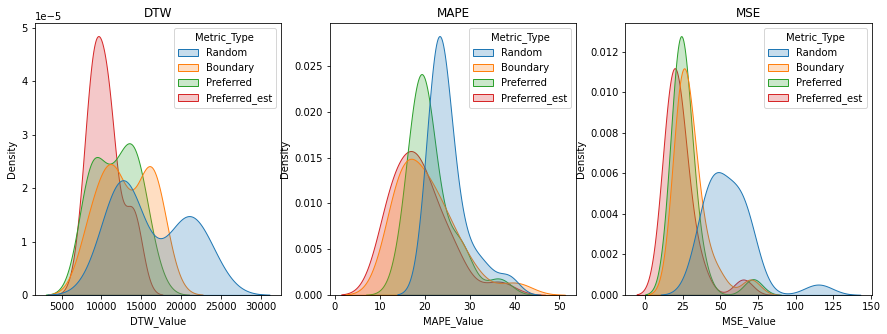

In [68]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig1 = sns.kdeplot(data=df_melted_DTW, x="DTW_Value", hue="Metric_Type", fill=True, ax=axes[0]).set(title='DTW')
fig_2 = sns.kdeplot(data=df_melted_mape, x="MAPE_Value", hue="Metric_Type", fill=True, ax=axes[1]).set(title='MAPE')
fig_3 = sns.kdeplot(data=df_melted_mse, x="MSE_Value", hue="Metric_Type", fill=True, ax=axes[2]).set(title='MSE')

In [ ]:
df_combined.head()

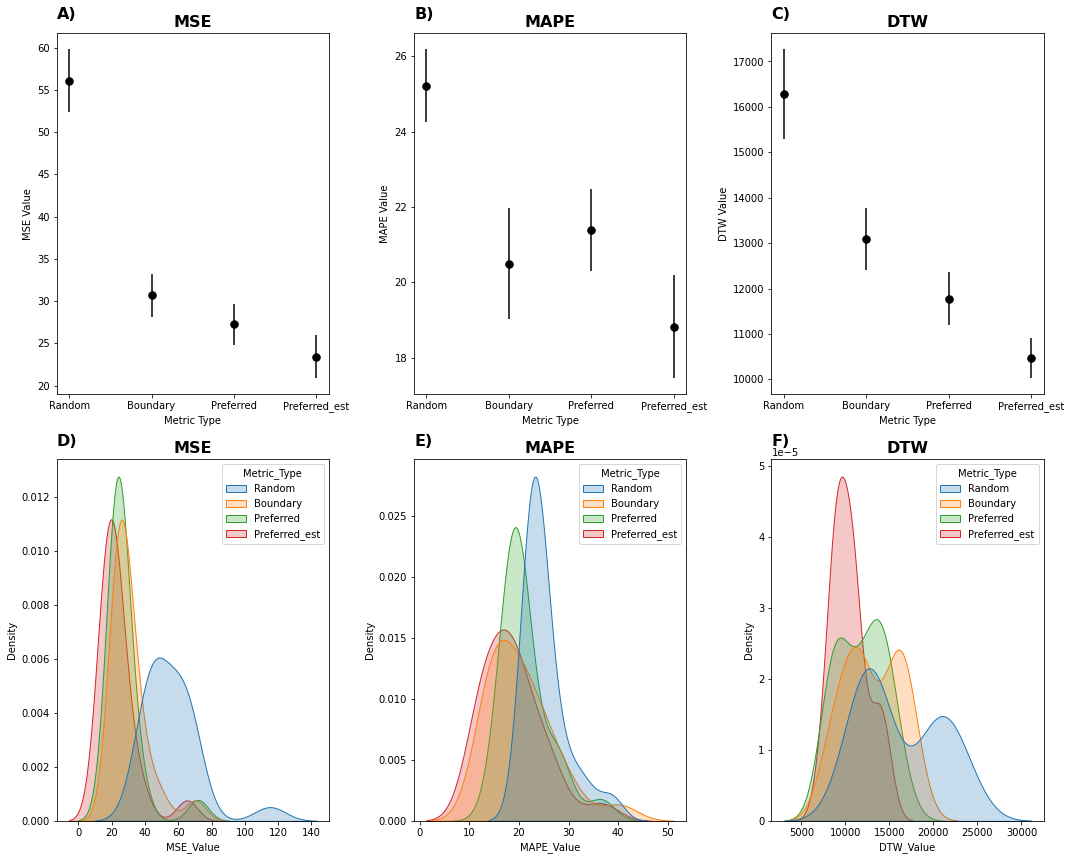

In [69]:
def calculate_mean_se(data, value_column, group_column):
    means = data.groupby(group_column)[value_column].mean()
    std_err = data.groupby(group_column)[value_column].sem()
    return means.index, means.values, std_err.values

# Calculate mean and standard error for DTW_Value, MAPE_Value, MSE_Value grouped by Metric_Type
m_dtw, means_dtw, std_err_dtw = calculate_mean_se(df_melted_DTW, 'DTW_Value', 'Metric_Type')
m_mape, means_mape, std_err_mape = calculate_mean_se(df_melted_mape, 'MAPE_Value', 'Metric_Type')
m_mse, means_mse, std_err_mse = calculate_mean_se(df_melted_mse, 'MSE_Value', 'Metric_Type')

# Create subplots with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 12))

# Plot errorbar for MSE_Value
axes[0,0].errorbar(m_mse, means_mse, yerr=std_err_mse, fmt='.', markersize=15,color='black')
axes[0,0].set_title('MSE', fontsize=16, fontweight='bold')
axes[0,0].set_xlabel('Metric Type')
axes[0,0].set_ylabel('MSE Value')
sns.kdeplot(data=df_melted_mse, x="MSE_Value", hue="Metric_Type", fill=True, ax=axes[1,0]).set(title='MSE')
axes[1,0].set_title('MSE', fontsize=16, fontweight='bold')

# Plot errorbar for MAPE_Value
axes[0,1].errorbar(m_mape, means_mape, yerr=std_err_mape, fmt='.', markersize=15,color='black')
axes[0,1].set_title('MAPE', fontsize=16, fontweight='bold')
axes[0,1].set_xlabel('Metric Type')
axes[0,1].set_ylabel('MAPE Value')
sns.kdeplot(data=df_melted_mape, x="MAPE_Value", hue="Metric_Type", fill=True, ax=axes[1,1])
axes[1,1].set_title('MAPE', fontsize=16, fontweight='bold')

# Plot errorbar for DTW_Value
axes[0,2].errorbar(m_dtw, means_dtw, yerr=std_err_dtw, fmt='.', markersize=15,color='black')
axes[0,2].set_title('DTW', fontsize=16, fontweight='bold')
axes[0,2].set_xlabel('Metric Type')
axes[0,2].set_ylabel('DTW Value')
sns.kdeplot(data=df_melted_DTW, x="DTW_Value", hue="Metric_Type", fill=True, ax=axes[1,2])
axes[1,2].set_title('DTW', fontsize=16, fontweight='bold')
# Add figure labels (A-F)
labels = ['A)', 'B)', 'C)', 'D)', 'E)', 'F)']
for i, ax in enumerate(axes.flatten()):
    ax.text(0, 1.05, labels[i], transform=ax.transAxes, fontsize=16, fontweight='bold', va='center')

# Adjust layout and display the plots
plt.tight_layout()
if impute == 'no':
    plt.savefig('/home/mremington/Documents/therma_sim/ibutton_data_analysis/Figures/TS_Dist.png', dpi=400)
else:
    plt.savefig('/home/mremington/Documents/therma_sim/ibutton_data_analysis/Figures/TS_Dist_imp.png', dpi=400)

plt.show()


In [ ]:
df.head()

In [ ]:
df.head()

# ANOVA ANALYSIS

In [50]:
# Mean Squared Error


# Interpret ANOVA results
alpha = 0.05
f_statistic, p_value = f_oneway(df['MSE_RAND'], df['MSE_BD'], df['MSE_NP'], df['MSE_P'])
print(f"Pvalue {p_value}")
if p_value < alpha:
    print("Reject null hypothesis: At least one group mean is significantly different.")
    # Perform Tukey's HSD test for pairwise comparisons
    groups = ['MSE_RAND', 'MSE_BD', 'MSE_NP', 'MSE_P']
    mse_values = pd.concat([df['MSE_RAND'], df['MSE_BD'], df['MSE_NP'], df['MSE_P']])
    labels = ['MSE_RAND'] * len(df['MSE_RAND']) + ['MSE_BD'] * len(df['MSE_BD']) + ['MSE_NP'] * len(df['MSE_NP']) + ['MSE_P'] * len(df['MSE_P'])
    tukey_results = pairwise_tukeyhsd(mse_values, labels)
    print("\nTukey's HSD test results:")
    print(tukey_results)
else:
    print("Cannot reject null hypothesis: Group means are not significantly different.")

Pvalue 4.139336120323644e-12
Reject null hypothesis: At least one group mean is significantly different.

Tukey's HSD test results:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1  group2  meandiff p-adj   lower    upper  reject
-------------------------------------------------------
MSE_BD   MSE_NP  -3.4305 0.8301 -14.0141  7.1531  False
MSE_BD    MSE_P  -7.2639 0.2806 -17.8474  3.3197  False
MSE_BD MSE_RAND  25.3832    0.0  14.7996 35.9668   True
MSE_NP    MSE_P  -3.8334 0.7777 -14.4169  6.7502  False
MSE_NP MSE_RAND  28.8137    0.0  18.2301 39.3973   True
 MSE_P MSE_RAND  32.6471    0.0  22.0635 43.2306   True
-------------------------------------------------------


In [ ]:
df_melted_mse.head(53)#['Metric_Type'].unique()

In [70]:
#MSE
model = smf.mixedlm('MSE_Value ~ C(Metric_Type) + C(Study_Site)', 
                    data=df_melted_mse, 
                    groups=df_melted_mse["Snake_Name"])
# Print the ANOVA table
result = model.fit()

summary_output = str(result.summary())
print(summary_output)

# Mape
model = smf.mixedlm('MAPE_Value ~ C(Metric_Type) + C(Study_Site)', 
                    data=df_melted_mape, 
                    groups=df_melted_mape["Snake_Name"])
# Print the ANOVA table
result = model.fit()

# Run ANOVA on the fitted result
summary_output = str(result.summary())
print(summary_output)

# DTW
model = smf.mixedlm('DTW_Value ~ C(Metric_Type) + C(Study_Site)', 
                    data=df_melted_DTW, 
                    groups=df_melted_DTW["Snake_Name"])
# Print the ANOVA table
result = model.fit()

# Run ANOVA on the fitted result
summary_output = str(result.summary())
print(summary_output)

                    Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        MSE_Value
No. Observations:          84             Method:                    REML     
No. Groups:                21             Scale:                     50.7021  
Min. group size:           4              Log-Likelihood:            -293.8179
Max. group size:           4              Converged:                 Yes      
Mean group size:           4.0                                                
------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------------------------
Intercept                        53.582    3.949  13.568 0.000  45.842  61.322
C(Metric_Type)[T.Boundary]      -25.383    2.197 -11.551 0.000 -29.690 -21.076
C(Metric_Type)[T.Preferred]     -28.814    2.197 -13.112 0.000 -33.121 -2

In [18]:
# 2. Model comparison (consider adding interaction terms)
model_interaction = smf.mixedlm('MSE_Value ~ C(Metric_Type) * C(Study_Site)', 
                                data=df_melted_mse, 
                                groups=df_melted_mse["Snake_Name"])
result_interaction = model_interaction.fit()

print("AIC - Model 1:", result.aic)
print("AIC - Model 2:", result_interaction.aic)
print("BIC - Model 1:", result.bic)
print("BIC - Model 2:", result_interaction.bic)


AIC - Model 1: nan
AIC - Model 2: nan
BIC - Model 1: nan
BIC - Model 2: nan


In [19]:
# MAPE
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway
# Interpret ANOVA results
alpha = 0.05
f_statistic, p_value = f_oneway(df['MAPE_RAND'], df['MAPE_BD'], df['MAPE_NP'], df['MAPE_P'])
print(f"Pvalue {p_value}")
if p_value < alpha:
    print("Reject null hypothesis: At least one group mean is significantly different.")
    # Perform Tukey's HSD test for pairwise comparisons
    groups = ['MAPE_RAND', 'MAPE_BD', 'MAPE_NP', 'MAPE_P']
    mse_values = pd.concat([df['MAPE_RAND'], df['MAPE_BD'], df['MAPE_NP'], df['MAPE_P']])
    labels = ['MAPE_RAND'] * len(df['MAPE_RAND']) + ['MAPE_BD'] * len(df['MAPE_BD']) + ['MAPE_NP'] * len(df['MAPE_NP']) + ['MAPE_P'] * len(df['MAPE_P'])
    tukey_results = pairwise_tukeyhsd(mse_values, labels)
    print("\nTukey's HSD test results:")
    print(tukey_results)
else:
    print("Cannot reject null hypothesis: Group means are not significantly different.")

Pvalue 0.011201540566210647
Reject null hypothesis: At least one group mean is significantly different.

Tukey's HSD test results:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
MAPE_BD   MAPE_NP   0.8849 0.9552 -3.6221 5.3919  False
MAPE_BD    MAPE_P  -0.6806 0.9788 -5.1876 3.8264  False
MAPE_BD MAPE_RAND   4.7181 0.0366  0.2111 9.2252   True
MAPE_NP    MAPE_P  -1.5655 0.7988 -6.0725 2.9416  False
MAPE_NP MAPE_RAND   3.8333 0.1235 -0.6738 8.3403  False
 MAPE_P MAPE_RAND   5.3987 0.0123  0.8917 9.9058   True
-------------------------------------------------------


In [ ]:
# DTW
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway
# Interpret ANOVA results
alpha = 0.05
f_statistic, p_value = f_oneway(df['DTW_RAND'], df['DTW_BD'], df['DTW_NP'], df['DTW_P'])
print(f"Pvalue {p_value}")
if p_value < alpha:
    print("Reject null hypothesis: At least one group mean is significantly different.")
    # Perform Tukey's HSD test for pairwise comparisons
    groups = ['DTW_RAND', 'DTW_BD', 'DTW_NP', 'DTW_P']
    mse_values = pd.concat([df['DTW_RAND'], df['DTW_BD'], df['DTW_NP'], df['DTW_P']])
    labels = ['DTW_RAND'] * len(df['DTW_RAND']) + ['DTW_BD'] * len(df['DTW_BD']) + ['DTW_NP'] * len(df['DTW_NP']) + ['DTW_P'] * len(df['DTW_P'])
    tukey_results = pairwise_tukeyhsd(mse_values, labels)
    print("\nTukey's HSD test results:")
    print(tukey_results)
else:
    print("Cannot reject null hypothesis: Group means are not significantly different.")

In [ ]:
# # Body Temperature
# from statsmodels.stats.multicomp import pairwise_tukeyhsd
# from scipy.stats import f_oneway
# # Interpret ANOVA results
# alpha = 0.05
# f_statistic, p_value = f_oneway(train['Body'], train['tb_sim_random'], train['tb_sim_bound'], train['tb_sim_np'], train['tb_sim_p'])
# print(f"Pvalue {p_value}")
# if p_value < alpha:
#     print("Reject null hypothesis: At least one group mean is significantly different.")
#     # Perform Tukey's HSD test for pairwise comparisons
#     groups = ['Body', 'tb_sim_random', 'tb_sim_bound', 'tb_sim_np', 'tb_sim_p']
#     mse_values = pd.concat([train['Body'], train['tb_sim_random'], train['tb_sim_bound'], train['tb_sim_np'], train['tb_sim_p']])
#     labels = ['Body'] * len(train['Body']) + ['tb_sim_random'] * len(train['tb_sim_random']) + ['tb_sim_bound'] * len(train['tb_sim_bound']) + ['tb_sim_np'] * len(train['tb_sim_np'])+ ['tb_sim_p'] * len(train['tb_sim_p'])
#     tukey_results = pairwise_tukeyhsd(mse_values, labels)
#     print("\nTukey's HSD test results:")
#     print(tukey_results)
# else:
#     print("Cannot reject null hypothesis: Group means are not significantly different.")

# Burrow Flip Analysis

In [ ]:
train[['Snake_Name', 'tb_sim_bound', 'Burrow_Usage_bound']]#.head(50)

In [ ]:
train['Burrow_Usage_np'].unique()

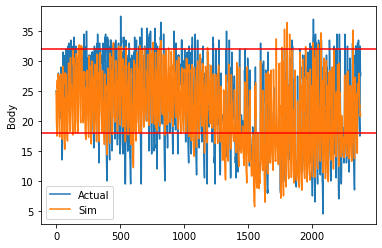

In [20]:
snake_name = 'Albert'
single_snake = train[train['Snake_Name']==snake_name].sort_values(['Date']).reset_index(drop=True)
full_ts = len(single_snake['Date'])
# t_max =1100
# t_min = 1000
t_max = full_ts
t_min = 0
sns.lineplot(x=list(range(t_min,t_max)), y=single_snake['Body'][t_min:t_max], label='Actual')
sns.lineplot(x=list(range(t_min,t_max)) , y=single_snake['tb_sim_p'][t_min:t_max], label='Sim')
plt.axhline(18, color='r')
plt.axhline(32, color='r')

In [ ]:
##############
## Retired
##############
single_snake_al = train[train['Snake_Name']=='Albert'].sort_values(['Date']).reset_index(drop=True)
single_snake_rag = train[train['Snake_Name']=='Ragnar'].sort_values(['Date']).reset_index(drop=True)
single_snake_bon = train[train['Snake_Name']=='Bonnie'].sort_values(['Date']).reset_index(drop=True)
# Create subplots (3 rows, 1 column)
var = ['tb_sim_random', 'tb_sim_bound', 'tb_sim_np', 'tb_sim_p']
label = ['random', 'boundary', 'preferred', 'preferred_est']
# t_max =7000
# t_min = 6000
#t_min = 0
# Create subplots (3 rows, 3 columns) for each snake
fig, axes = plt.subplots(3, 4, figsize=(18, 14), sharex=False, sharey=True)

# Plot each snake's data on separate subplots
for i, (snake_data, snake_name) in enumerate(zip([single_snake_al, single_snake_rag, single_snake_bon], ['Canada - Albert', 'Nebraska - Ragnar', 'Texas - Bonnie'])):
    for j, v in enumerate(var):
#         t_min=0
#         t_max=range(len(snake_data))
        t_max = 2000
        t_min = 1000
        ax = axes[i, j]
        sns.lineplot(x=range(t_min, t_max), y=snake_data[v][t_min:t_max], label=label[j], ax=ax)
        sns.lineplot(x=range(t_min, t_max), y=snake_data['Body'][t_min:t_max], label='Actual', ax=ax)
        ax.set_title(f'{snake_name} - {label[j]}')
        ax.set_ylabel('Body Temperature (c)')
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        ax.axhline(18, color='r')  # Horizontal line at 18
        ax.axhline(32, color='r')  # Horizontal line at 32

# Add legend and labels to the last subplot
axes[-1, -1].legend()
axes[-1, -1].set_xlabel('Time Steps')

# if impute=='yes':
#     plt.suptitle('15 min Sample Frequency', fontsize=16, fontweight='bold', y=0.92)
#     plt.savefig('/home/mremington/Documents/therma_sim/ibutton_data_analysis/Figures/ts_plot_matrix_imp.png')
# else:
#     plt.suptitle('15 min Sample Frequency', fontsize=16, fontweight='bold', y=0.92)
#     plt.tight_layout
#     plt.savefig('/home/mremington/Documents/therma_sim/ibutton_data_analysis/Figures/ts_plot_matrix.png')

In [ ]:
snake_name_to_id ={
    'Albert': 'EDCRVI003',
    'Cooper': 'EDCRVI004',
    'Eddie': 'EDCRVI001',
    'Hector': 'EDCRVI002',
    'Hunter': 'EDCRVI015',
    'Kokanee': 'EDCRVI013',
    'Manitoba': 'EDCRVI005',
    'Moose': 'EDCRVI006',
    'Paloma': 'EDCRVI016',
    'Victor': 'EDCRVI010',
    'Horace': 'NVCRVI037',
    'Ragnar': 'NVCRVI030',
    'Bonnie': 'MGCRVI021',
    'Caezar': 'MGCRVI015',
    'Cecilia': 'MGCRVI014',
    'Cher': 'MGCRVI013',
    'Cladwell': 'MGCRVI011',
    'Janis': 'MGCRVI010',
    'Nando': 'MGCRVI008',
    'Ringo': 'MGCRVI003',
    'Tornado': 'MGCRVI009'
}

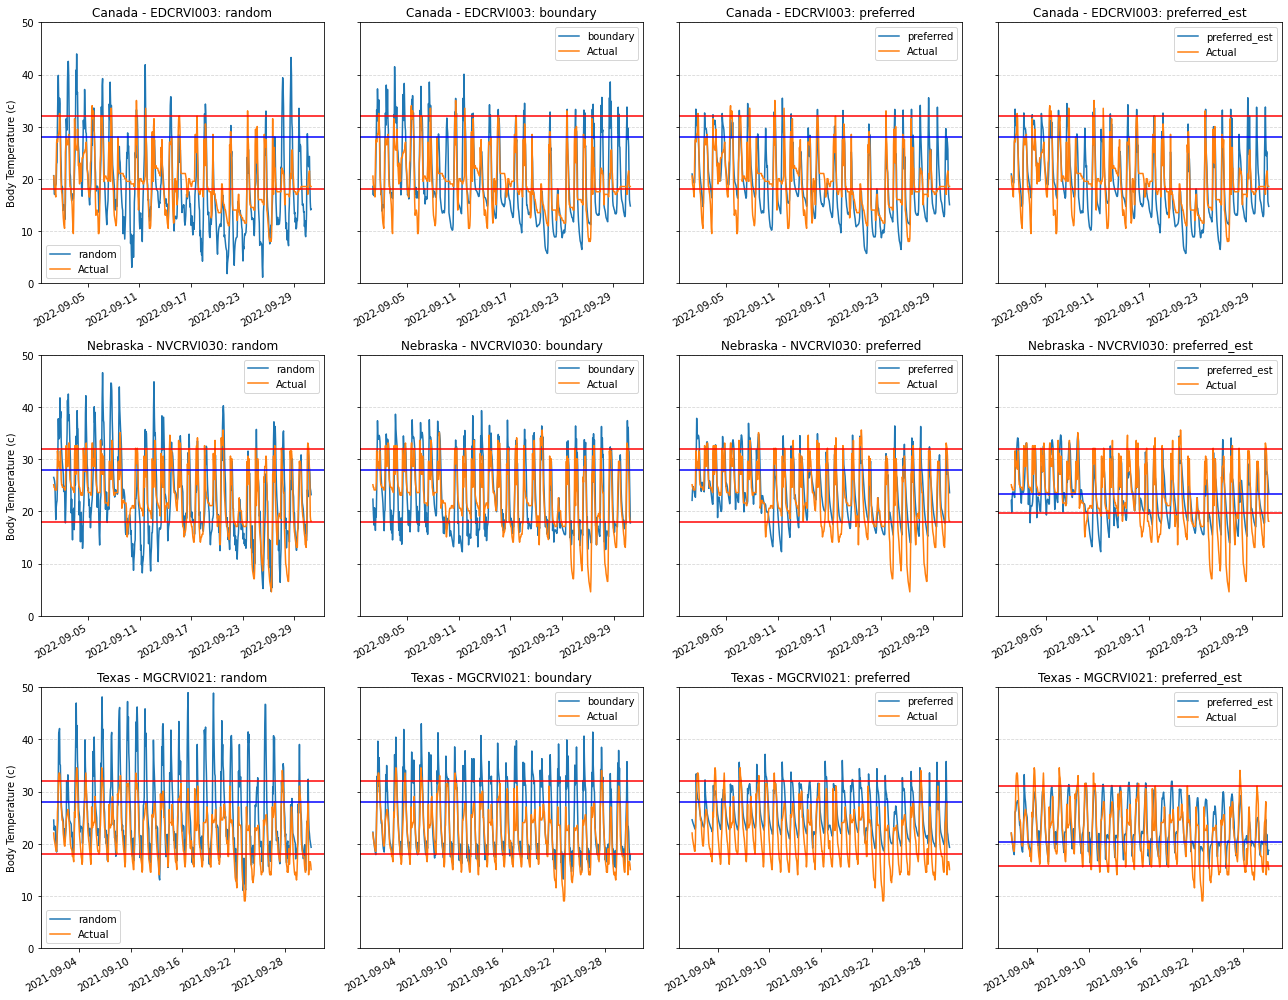

In [13]:
single_snake_al = train[(train['Snake_Name'] == 'EDCRVI003') & (train['Date'].dt.month == 9)].sort_values(['Date']).reset_index(drop=True)
single_snake_rag = train[(train['Snake_Name'] == 'NVCRVI030') & (train['Date'].dt.month == 9)].sort_values(['Date']).reset_index(drop=True)
single_snake_bon = train[(train['Snake_Name'] == 'MGCRVI021') & (train['Date'].dt.month == 9)].sort_values(['Date']).reset_index(drop=True)

### Parameter Est
#snake_data = sim_para[sim_para['Snake_Name'] == snake_name][['Study_Site', 't_pref_min', 't_pref_max', 't_opt']]

# Create subplots (3 rows, 1 column)
var = ['tb_sim_random', 'tb_sim_bound', 'tb_sim_np', 'tb_sim_p']
label = ['random', 'boundary', 'preferred', 'preferred_est']
# t_max =7000
# t_min = 6000
#t_min = 0
# Create subplots (3 rows, 3 columns) for each snake
fig, axes = plt.subplots(3, 4, figsize=(18, 14), sharex=False, sharey=True)

# Plot each snake's data on separate subplots
for i, (snake_data, snake_name) in enumerate(zip([single_snake_al, single_snake_rag, single_snake_bon], ['Canada - EDCRVI003', 'Nebraska - NVCRVI030', 'Texas - MGCRVI021'])):
    for j, v in enumerate(var):
#         t_min=0
#         t_max=range(len(snake_data))

        t_max = 2000
        t_min = 1000
        snake = snake_name.split('- ')[1]
        ax = axes[i, j]
        sns.lineplot(x=snake_data['Date'], y=snake_data[v], label=label[j], ax=ax)
        sns.lineplot(x=snake_data['Date'], y=snake_data['Body'], label='Actual', ax=ax)
        ax.set_title(f'{snake_name}: {label[j]}')
        ax.set_ylabel('Body Temperature (c)')
        ax.set_xlabel('')
        ax.set_ylim(0,50)
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        if label[j] == 'preferred_est':
            para = sim_para[sim_para['Snake_Name'] == snake]
            t_pref_min = para['t_pref_min'].values[0]
            t_pref_max = para['t_pref_max'].values[0]
            t_opt = para['t_opt'].values[0]
        else:
            t_pref_min = 18
            t_pref_max = 32
            t_opt = 28
        ax.axhline(t_pref_min, color='r')  # Horizontal line at 18
        ax.axhline(t_pref_max, color='r')  # Horizontal line at 32
        ax.axhline(t_opt, color='b')
        ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=6))  # Set desired number of ticks
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=30, ha='right')  # Rotate labels by 45 degrees


# Add legend and labels to the last subplot
axes[-1, -1].legend()

plt.tight_layout()
if impute=='yes':
    plt.suptitle('15 min Sample Frequency', fontsize=16, fontweight='bold', y=1.01)
    plt.savefig('/home/mremington/Documents/therma_sim/ibutton_data_analysis/Figures/ts_plot_matrix_imp.png')
else:
    #plt.suptitle('70 min Sample Frequency', fontsize=16, fontweight='bold', y=1.01)
    plt.savefig('/home/mremington/Documents/therma_sim/ibutton_data_analysis/Figures/ts_plot_matrix.png')

In [ ]:
help(sns.lineplot)

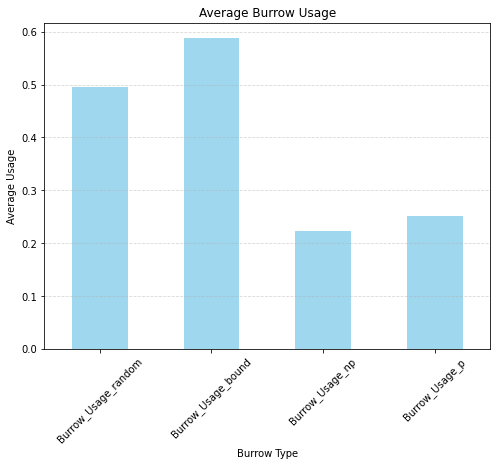

In [23]:
bu = ['Burrow_Usage_random', 'Burrow_Usage_bound', 'Burrow_Usage_np', 'Burrow_Usage_p']
# Calculate sum of specified columns
sum_bu = train[bu].sum()

# Calculate length of the DataFrame
length_df = len(train)

# Divide each sum by the length of the DataFrame
average_bu = sum_bu / length_df
average_bu.index
# Plotting the averages
plt.figure(figsize=(8, 6))
average_bu.plot(kind='bar', color='skyblue', alpha=0.8)

# Customize the plot
plt.title('Average Burrow Usage')
plt.xlabel('Burrow Type')
plt.ylabel('Average Usage')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

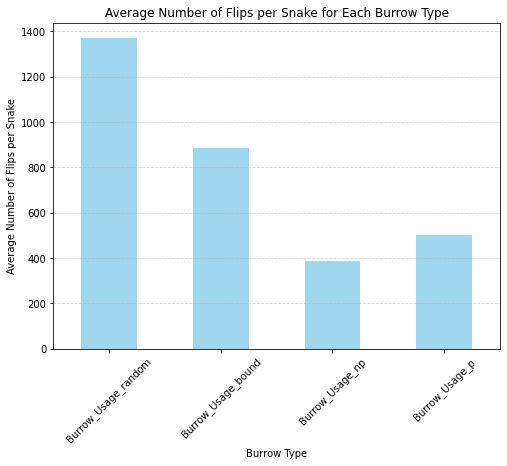

In [24]:
# Create a new DataFrame for storing the results
change_df = pd.DataFrame()

def detect_changes(group):
    change_df = pd.DataFrame()
    for col in bu:
        change_series = group[col].ne(group[col].shift()).astype(int)
        change_df[col] = change_series
    return change_df

# Apply the function on each group defined by 'Snake_Name'
change_by_snake = train.groupby('Snake_Name').apply(detect_changes)

# Reset the index of the resulting DataFrame
change_by_snake.reset_index(drop=True, inplace=True)

# Calculate the total number of snakes
num_snakes = len(train['Snake_Name'].unique())

# Calculate the sum of flips across all snakes for each burrow type
sum_flips = change_by_snake.sum()

# Calculate the average number of flips per snake for each burrow type
average_flips_per_snake = sum_flips / num_snakes

# Plotting the average number of flips per snake for each burrow type
plt.figure(figsize=(8, 6))
average_flips_per_snake.plot(kind='bar', color='skyblue', alpha=0.8)

# Customize the plot
plt.title('Average Number of Flips per Snake for Each Burrow Type')
plt.xlabel('Burrow Type')
plt.ylabel('Average Number of Flips per Snake')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Plotting the averages
# plt.figure(figsize=(8, 6))
# sum_change.plot(kind='bar', color='skyblue', alpha=0.8)

# # Customize the plot
# plt.title('Number of flips')
# plt.xlabel('Burrow Type')
# plt.ylabel('Number of flips')
# plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.5)

In [ ]:
average_flips_per_snake

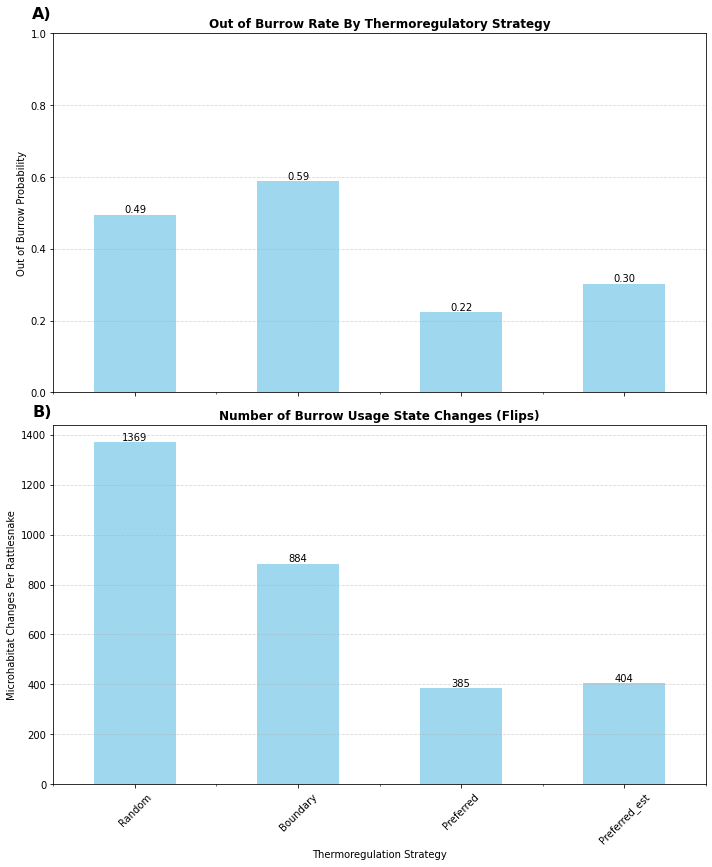

In [72]:
%matplotlib inline
# Define the burrow usage columns of interest
bu = ['Burrow_Usage_random', 'Burrow_Usage_bound', 'Burrow_Usage_np', 'Burrow_Usage_p']

# Function to detect changes (flips) in burrow usage
def detect_changes(group):
    change_df = pd.DataFrame()
    for col in bu:
        change_series = group[col].ne(group[col].shift()).astype(int)
        change_df[col] = change_series
    return change_df

# Apply the function on each group defined by 'Snake_Name'
change_by_snake = train.groupby('Snake_Name').apply(detect_changes)

# Calculate the sum of changes (flips) across burrow types
sum_change = change_by_snake[bu].sum()
num_snakes = len(train['Snake_Name'].unique())

# Calculate the average number of flips per snake for each burrow type
average_flips_per_snake = sum_change / num_snakes

# Calculate average burrow usage
average_bu = train[bu].mean()

fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Plot average burrow usage
average_bu.plot(kind='bar', color='skyblue', alpha=0.8, ax=axes[0])

# Annotate bars with rounded values
for i, v in enumerate(average_bu):
    axes[0].text(i, v,  f'{round(v,2):.2f}', ha='center', va='bottom')

# Customize the plot for average burrow usage
axes[0].set_title('Out of Burrow Rate By Thermoregulatory Strategy', fontweight='bold')
axes[0].set_ylabel('Out of Burrow Probability')
axes[0].set_ylim(0, 1)
axes[0].set_xticklabels(['Random', 'Boundary', 'Preferred', 'Preferred_est'], rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Plot number of flips (changes) in burrow usage
average_flips_per_snake.plot(kind='bar', color='skyblue', alpha=0.8, ax=axes[1])

# Annotate bars with rounded values
for i, v in enumerate(average_flips_per_snake):
    axes[1].text(i, v + 0.5, f'{int(v)}', ha='center', va='bottom')

# Customize the plot for number of flips
axes[1].set_title('Number of Burrow Usage State Changes (Flips)', fontweight='bold')
axes[1].set_xlabel('Thermoregulation Strategy')
axes[1].set_ylabel('Microhabitat Changes Per Rattlesnake')
axes[1].set_xticklabels(['Random', 'Boundary', 'Preferred', 'Preferred_est'], rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

# Add figure labels outside the plot area
fig.text(0.05, 1.0, 'A)', fontsize=16, fontweight='bold', va='top', ha='left')
fig.text(0.05, 0.54, 'B)', fontsize=16, fontweight='bold', va='top', ha='left')

# Adjust layout and display the plot
plt.tight_layout()

if impute == 'no':
    plt.savefig('/home/mremington/Documents/therma_sim/ibutton_data_analysis/Figures/burrow_bars.png',dpi=300)
else:
    plt.savefig('/home/mremington/Documents/therma_sim/ibutton_data_analysis/Figures/burrow_bars_imp.png',dpi=300)
plt.show()

## ThermaStats

In [ ]:
train.head()

In [10]:
def thermal_quality_calc(t_pref_min, t_pref_max, t_env):
    if t_env < t_pref_min:
        de = np.abs(float(t_pref_min) - t_env)
    elif t_env > t_pref_max:
        de = np.abs(float(t_pref_max) - t_env)
    else:
        de = 0
    return de

def thermo_accuracy_calc(t_pref_min, t_pref_max, t_body):
    if t_body < t_pref_min:
        db = np.abs(float(t_pref_min) - float(t_body))
    elif t_body > t_pref_max:
        db = np.abs(float(t_pref_max) - float(t_body))
    else:
        db = 0.0
    return db

def thermal_quality(Tmod, Tset_min, Tset_max):
    """
    Calculate thermal quality (de), which is the absolute difference between the modeled temperature
    (Tmod) and the preferred body temperature range (Tset_min, Tset_max).
    """
    # If Tmod is within the preferred range, de = 0, else de = min(abs(Tmod - Tset_min), abs(Tmod - Tset_max))
    de = np.where((Tmod >= Tset_min) & (Tmod <= Tset_max), 0, np.minimum(np.abs(Tmod - Tset_min), np.abs(Tmod - Tset_max)))
    return de

def thermoregulatory_accuracy(Tb, Tset_min, Tset_max):
    """
    Calculate thermoregulatory accuracy (db), which is the absolute difference between the
    snake's body temperature (Tb) and the preferred body temperature range (Tset_min, Tset_max).
    """
    # Similar logic: if Tb is within the preferred range, db = 0, else db = min(abs(Tb - Tset_min), abs(Tb - Tset_max))
    db = np.where((Tb >= Tset_min) & (Tb <= Tset_max), 0, np.minimum(np.abs(Tb - Tset_min), np.abs(Tb - Tset_max)))
    return db

def thermo_eff_i(db, de):
    return de-db

## Agg indicies

def thermo_eff_e(group):
    mean_db = group['thermal_effectivness_e'].mean()
    mean_de = group['thermal_quality_de'].mean()
    if mean_de > 0:
        e = 1 - (mean_db / mean_de)
    else:
        e = np.nan
    return pd.Series({'Thermal_Efficiency': e})


def thermo_exploitation(de):
    if de==0:
        ex=1
    else:
        ex=0
    return ex

In [11]:
strategy_dict = {'random':['Burrow_Usage_random', 'tb_sim_random'],
                'boundary':['Burrow_Usage_bound', 'tb_sim_bound'],
                'preferred_np':['Burrow_Usage_np', 'tb_sim_np'],
                'preferred_p':['Burrow_Usage_p', 'tb_sim_p']}

### Thermal Indicies
# rand
thermal_quality_random = []
thermo_accuracy_random = []
thermo_effectivness_random = []
thermo_exploitation_random = []
# bound
thermal_quality_boundary = []
thermo_accuracy_boundary = []
thermo_effectivness_boundary = []
thermo_exploitation_boundary = []
# pref_np
thermal_quality_preferred_np = []
thermo_accuracy_preferred_np = []
thermo_effectivness_preferred_np = []
thermo_exploitation_preferred_np = []
# pref_np
thermal_quality_preferred_p = []
thermo_accuracy_preferred_p = []
thermo_effectivness_preferred_p = []
thermo_exploitation_preferred_p = []

for strategy, labels in strategy_dict.items():
    body_temp_label = labels[1]
    print(body_temp_label)
    burrow_usage_label = labels[0]
    print(burrow_usage_label)
    for index, row in train.iterrows():
        t_body=row[body_temp_label]
        if row[burrow_usage_label]==1:
            t_env=row['Open']
        else:
            t_env=row['Burrow']
#         if strategy == 'preferred_p':
#             snake = row['Snake_Name']
#             para = sim_para[sim_para['Snake_Name'] == snake]
#             t_pref_min = para['t_pref_min'].values[0]
#             t_pref_max = para['t_pref_max'].values[0]
#             t_opt = para['t_opt'].values[0]
#         else:
        t_pref_min = 18
        t_pref_max = 32
        t_opt = 28
        de = thermal_quality(Tmod=t_env, Tset_min=t_pref_min, Tset_max=t_pref_max)
        db = thermoregulatory_accuracy(Tb=t_body, Tset_min=t_pref_min, Tset_max=t_pref_max)
        i = thermo_eff_i(db, de)
        ex = thermo_exploitation(de)
        if strategy == 'random':
            thermal_quality_random.append(de)
            thermo_accuracy_random.append(db)
            thermo_effectivness_random.append(i)
            thermo_exploitation_random.append(ex)
        elif strategy == 'boundary':
            thermal_quality_boundary.append(de)
            thermo_accuracy_boundary.append(db)
            thermo_effectivness_boundary.append(i)
            thermo_exploitation_boundary.append(ex)
        elif strategy == 'preferred_np':
            thermal_quality_preferred_np.append(de)
            thermo_accuracy_preferred_np.append(db)
            thermo_effectivness_preferred_np.append(i)
            thermo_exploitation_preferred_np.append(ex)
        elif strategy == 'preferred_p':
            thermal_quality_preferred_p.append(de)
            thermo_accuracy_preferred_p.append(db)
            thermo_effectivness_preferred_p.append(i)
            thermo_exploitation_preferred_p.append(ex)

train['random_thermal_quality_de'] = thermal_quality_random
train['random_thermal_accuracy_db'] = thermo_accuracy_random
train['random_thermal_effectivness_i'] = thermo_effectivness_random
train['random_thermal_exploitation_ex'] = thermo_exploitation_random

train['boundary_thermal_quality_de'] = thermal_quality_boundary
train['boundary_thermal_accuracy_db'] = thermo_accuracy_boundary
train['boundary_thermal_effectivness_i'] = thermo_effectivness_boundary
train['boundary_thermal_exploitation_ex'] = thermo_exploitation_boundary

train['preferred_np_thermal_quality_de'] = thermal_quality_preferred_np
train['preferred_np_thermal_accuracy_db'] = thermo_accuracy_preferred_np
train['preferred_np_thermal_effectivness_i'] = thermo_effectivness_preferred_np
train['preferred_np_thermal_exploitation_ex'] = thermo_exploitation_preferred_np

train['preferred_p_thermal_quality_de'] = thermal_quality_preferred_p
train['preferred_p_thermal_accuracy_db'] = thermo_accuracy_preferred_p
train['preferred_p_thermal_effectivness_i'] = thermo_effectivness_preferred_p
train['preferred_p_thermal_exploitation_ex'] = thermo_exploitation_preferred_p

hourly_means = train[['Hour',
                      "random_thermal_quality_de",
                      "boundary_thermal_quality_de",
                      "preferred_np_thermal_quality_de",
                      "preferred_p_thermal_quality_de",
                      'random_thermal_accuracy_db',
                      'boundary_thermal_accuracy_db',
                      'preferred_np_thermal_accuracy_db',
                      'preferred_p_thermal_accuracy_db',
                      'random_thermal_effectivness_i',
                      'boundary_thermal_effectivness_i',
                      'preferred_np_thermal_effectivness_i',
                      'preferred_p_thermal_effectivness_i',
                      'random_thermal_exploitation_ex',
                      'boundary_thermal_exploitation_ex',
                      'preferred_np_thermal_exploitation_ex',
                      'preferred_p_thermal_exploitation_ex',
                      'Burrow_Usage_random',
                      'Burrow_Usage_bound',
                      'Burrow_Usage_np',
                      'Burrow_Usage_p']].groupby('Hour').mean()

strategy_dict = {'random':['random_thermal_quality_de', 'random_thermal_accuracy_db'],
                'boundary':['boundary_thermal_quality_de', 'boundary_thermal_accuracy_db'],
                'preferred_np':['preferred_np_thermal_quality_de', 'preferred_np_thermal_accuracy_db'],
                'preferred_p':['preferred_p_thermal_quality_de', 'preferred_p_thermal_accuracy_db']}

# thermal_effecivness_dict = {'random':[],
#                 'boundary':[],
#                 'preferred_np':[],
#                 'preferred_p':[]}
for strategy, variable in strategy_dict.items():
    de = hourly_means[variable[0]]
    db = hourly_means[variable[1]]
    thermal_effectivness = 1 - de/db
    label = strategy + "_thermal_effectivness_e"
    hourly_means[label] = thermal_effectivness
    

tb_sim_random
Burrow_Usage_random
tb_sim_bound
Burrow_Usage_bound
tb_sim_np
Burrow_Usage_np
tb_sim_p
Burrow_Usage_p


In [ ]:
train['random_thermal_quality_de'].head()

In [ ]:
hourly_means.head()

In [ ]:
## Redo thermo effectivness

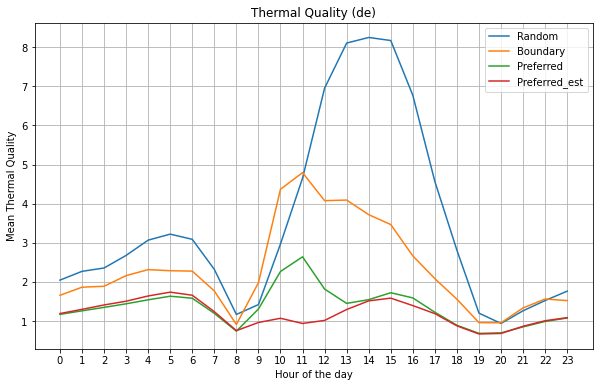

In [28]:
columns = ["random_thermal_quality_de", "boundary_thermal_quality_de", "preferred_np_thermal_quality_de", "preferred_p_thermal_quality_de"]
labels = ['Random', 'Boundary', 'Preferred', 'Preferred_est']
plt.figure(figsize=(10, 6))
for i, column in enumerate(columns):
    plt.plot(hourly_means.index, hourly_means[column], label=labels[i])

plt.xlabel('Hour of the day')
plt.ylabel('Mean Thermal Quality')
plt.title('Thermal Quality (de)')
plt.xticks(np.arange(0, 24, 1))
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
columns = ["random_thermal_accuracy_db",
           "boundary_thermal_accuracy_db",
           "preferred_np_thermal_accuracy_db",
           "preferred_p_thermal_accuracy_db"]
labels = ['Random', 'Boundary', 'Preferred', 'Preferred_est']

plt.figure(figsize=(10, 6))
for i, column in enumerate(columns):
    plt.plot(hourly_means.index, hourly_means[column], label=labels[i])

plt.xlabel('Hour of the day')
plt.ylabel('Mean Thermal Accuracy')
plt.title('Thermal Accuracy (db)')
plt.xticks(np.arange(0, 24, 1))
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
hourly_means.head()

In [ ]:
# Calc Thermal Effectivness (E)
# strategy_dict = {'random':['random_thermal_quality_de', 'random_thermal_accuracy_db'],
#                 'boundary':['boundary_thermal_quality_de', 'boundary_thermal_accuracy_db'],
#                 'preferred_np':['preferred_np_thermal_quality_de', 'preferred_np_thermal_accuracy_db'],
#                 'preferred_p':['preferred_p_thermal_quality_de', 'preferred_p_thermal_accuracy_db']}

# thermal_effecivness_dict = {'random':[],
#                 'boundary':[],
#                 'preferred_np':[],
#                 'preferred_p':[]}
# for strategy, variable in strategy_dict.items():
#     de = hourly_means[variable[0]]
#     db = hourly_means[variable[1]]
#     thermal_effectivness = 1 - de/db
#     label = strategy + "_thermal_effectivness_e"
#     hourly_means[label] = thermal_effectivness
    
# columns = ["random_thermal_effectivness_e",
#            "boundary_thermal_effectivness_e",
#            "preferred_np_thermal_effectivness_e",
#            "preferred_p_thermal_effectivness_e"]

# plt.figure(figsize=(10, 6))
# for column in columns:
#     plt.plot(hourly_means.index, hourly_means[column], label=column)

# plt.xlabel('Hour of the day')
# plt.ylabel('Thermal Effectiness (E)')
# plt.title('Thermal Effectivness (E)')
# plt.xticks(np.arange(0, 24, 1))
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
# Calc Thermal Exploitativness (Ex)
columns = ["random_thermal_exploitation_ex",
           "boundary_thermal_exploitation_ex",
           "preferred_np_thermal_exploitation_ex",
           "preferred_p_thermal_exploitation_ex"]
labels = ['Random', 'Boundary', 'Preferred', 'Preferred_est']
plt.figure(figsize=(10, 6))
for i, column in enumerate(columns):
    plt.plot(hourly_means.index, hourly_means[column], label=labels[i])

plt.xlabel('Hour of the day')
plt.ylabel('Thermal Exploitation')
plt.title('Thermal Exploitation (Ex)')
plt.xticks(np.arange(0, 24, 1))
plt.ylim(0,1)
plt.legend()
plt.grid(True)
plt.show()

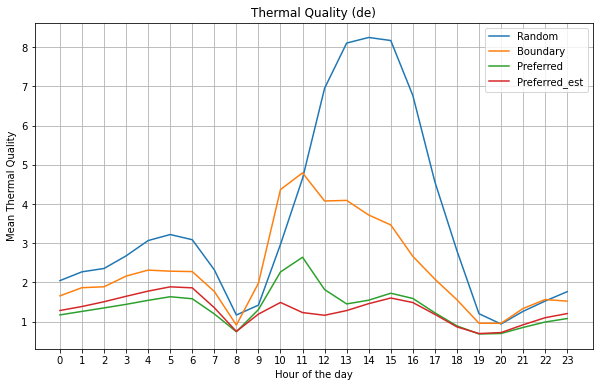

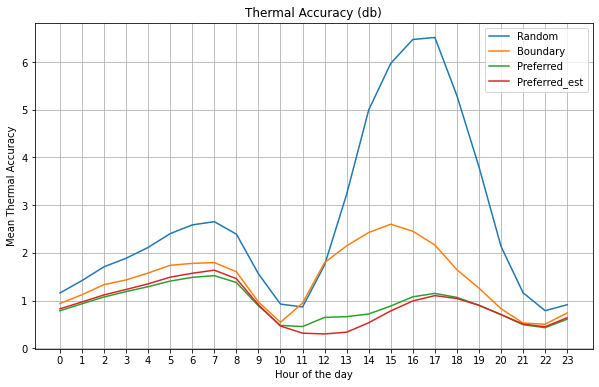

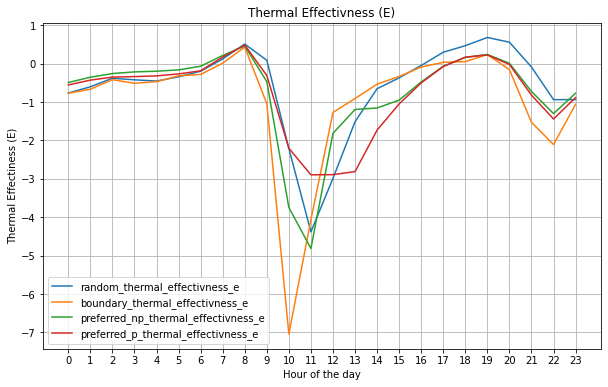

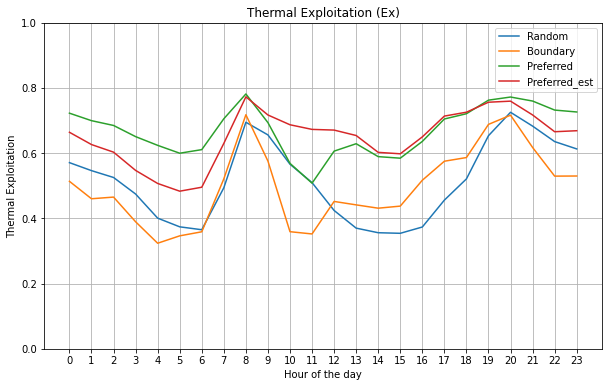

In [56]:
columns = ["random_thermal_quality_de", "boundary_thermal_quality_de", "preferred_np_thermal_quality_de", "preferred_p_thermal_quality_de"]
labels = ['Random', 'Boundary', 'Preferred', 'Preferred_est']
plt.figure(figsize=(10, 6))
for i, column in enumerate(columns):
    plt.plot(hourly_means.index, hourly_means[column], label=labels[i])

plt.xlabel('Hour of the day')
plt.ylabel('Mean Thermal Quality')
plt.title('Thermal Quality (de)')
plt.xticks(np.arange(0, 24, 1))
plt.legend()
plt.grid(True)
plt.show()

columns = ["random_thermal_accuracy_db",
           "boundary_thermal_accuracy_db",
           "preferred_np_thermal_accuracy_db",
           "preferred_p_thermal_accuracy_db"]
labels = ['Random', 'Boundary', 'Preferred', 'Preferred_est']

plt.figure(figsize=(10, 6))
for i, column in enumerate(columns):
    plt.plot(hourly_means.index, hourly_means[column], label=labels[i])

plt.xlabel('Hour of the day')
plt.ylabel('Mean Thermal Accuracy')
plt.title('Thermal Accuracy (db)')
plt.xticks(np.arange(0, 24, 1))
plt.legend()
plt.grid(True)
plt.show()

strategy_dict = {'random':['random_thermal_quality_de', 'random_thermal_accuracy_db'],
                'boundary':['boundary_thermal_quality_de', 'boundary_thermal_accuracy_db'],
                'preferred_np':['preferred_np_thermal_quality_de', 'preferred_np_thermal_accuracy_db'],
                'preferred_p':['preferred_p_thermal_quality_de', 'preferred_p_thermal_accuracy_db']}

thermal_effecivness_dict = {'random':[],
                'boundary':[],
                'preferred_np':[],
                'preferred_p':[]}
for strategy, variable in strategy_dict.items():
    de = hourly_means[variable[0]]
    db = hourly_means[variable[1]]
    thermal_effectivness = 1 - de/db
    label = strategy + "_thermal_effectivness_e"
    hourly_means[label] = thermal_effectivness
    
columns = ["random_thermal_effectivness_e",
           "boundary_thermal_effectivness_e",
           "preferred_np_thermal_effectivness_e",
           "preferred_p_thermal_effectivness_e"]

plt.figure(figsize=(10, 6))
for column in columns:
    plt.plot(hourly_means.index, hourly_means[column], label=column)

plt.xlabel('Hour of the day')
plt.ylabel('Thermal Effectiness (E)')
plt.title('Thermal Effectivness (E)')
plt.xticks(np.arange(0, 24, 1))
plt.legend()
plt.grid(True)
plt.show()

columns = ["random_thermal_exploitation_ex",
           "boundary_thermal_exploitation_ex",
           "preferred_np_thermal_exploitation_ex",
           "preferred_p_thermal_exploitation_ex"]
labels = ['Random', 'Boundary', 'Preferred', 'Preferred_est']
plt.figure(figsize=(10, 6))
for i, column in enumerate(columns):
    plt.plot(hourly_means.index, hourly_means[column], label=labels[i])

plt.xlabel('Hour of the day')
plt.ylabel('Thermal Exploitation')
plt.title('Thermal Exploitation (Ex)')
plt.xticks(np.arange(0, 24, 1))
plt.ylim(0,1)
plt.legend()
plt.grid(True)
plt.show()

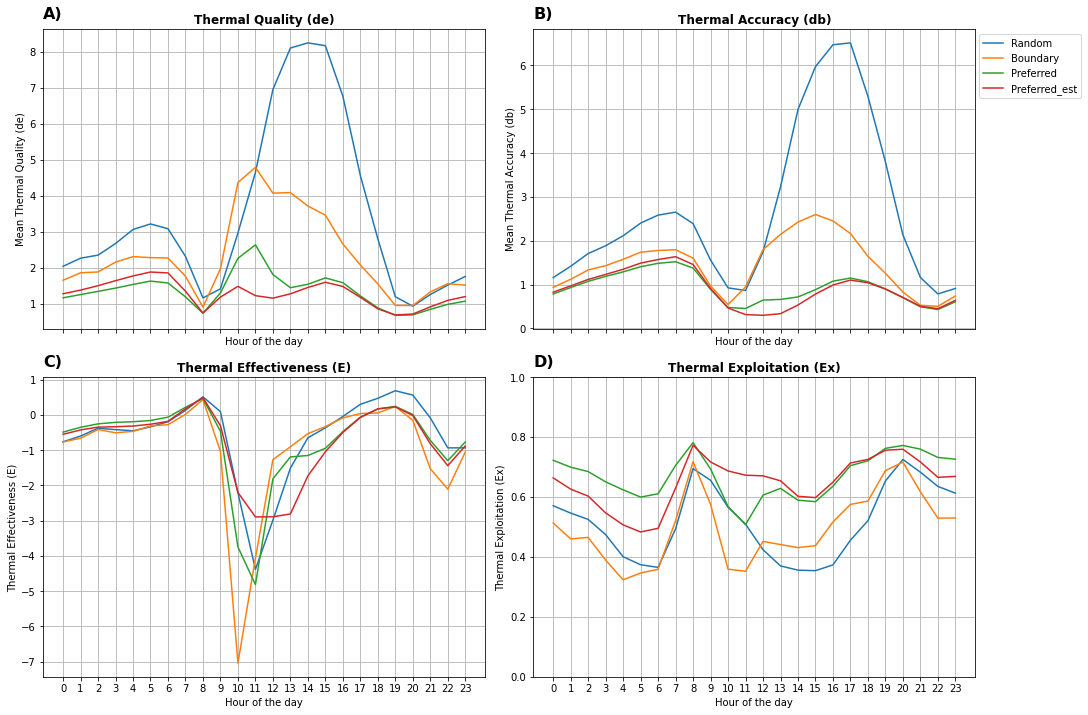

In [75]:
# Define the data
columns_quality = ["random_thermal_quality_de", 
                   "boundary_thermal_quality_de", 
                   "preferred_np_thermal_quality_de", 
                   "preferred_p_thermal_quality_de"]
labels_quality = ['Random', 'Boundary', 'Preferred', 'Preferred_est']

columns_accuracy = ["random_thermal_accuracy_db",
                    "boundary_thermal_accuracy_db",
                    "preferred_np_thermal_accuracy_db",
                    "preferred_p_thermal_accuracy_db"]
labels_accuracy = ['Random', 'Boundary', 'Preferred', 'Preferred_est']

columns_effectiveness = ["random_thermal_effectivness_e",
                         "boundary_thermal_effectivness_e",
                         "preferred_np_thermal_effectivness_e",
                         "preferred_p_thermal_effectivness_e"]
labels_effectiveness = ['Random', 'Boundary', 'Preferred', 'Preferred_est']

# Create a 2x2 subplot grid for thermal quality, accuracy, and effectiveness
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharex=True)

# Plot thermal quality (top left)
for i, (column, label) in enumerate(zip(columns_quality, labels_quality)):
    ax = axs[0, 0]  # Top left subplot
    ax.plot(hourly_means.index, hourly_means[column], label=label)
    ax.set_xlabel('Hour of the day')
    ax.set_ylabel('Mean Thermal Quality (de)')
    ax.set_title('Thermal Quality (de)', fontweight='bold')
    ax.set_xticks(np.arange(0, 24, 1))
    #ax.legend()
    ax.grid(True)

# Plot thermal accuracy (top right)
for i, (column, label) in enumerate(zip(columns_accuracy, labels_accuracy)):
    ax = axs[0, 1]  # Top right subplot
    ax.plot(hourly_means.index, hourly_means[column], label=label)
    ax.set_xlabel('Hour of the day')
    ax.set_ylabel('Mean Thermal Accuracy (db)')
    ax.set_title('Thermal Accuracy (db)', fontweight='bold')
    ax.set_xticks(np.arange(0, 24, 1))
    ax.legend(loc='upper right', bbox_to_anchor=(1.25,1))
    ax.grid(True)

# Plot thermal effectiveness (bottom left)
for i, (column, label) in enumerate(zip(columns_effectiveness, labels_effectiveness)):
    ax = axs[1, 0]  # Bottom left subplot
    ax.plot(hourly_means.index, hourly_means[column], label=label)
    ax.set_xlabel('Hour of the day')
    ax.set_ylabel('Thermal Effectiveness (E)')
    ax.set_title('Thermal Effectiveness (E)', fontweight='bold')
    ax.set_xticks(np.arange(0, 24, 1))
    #ax.legend()
    ax.grid(True)

# Plot thermal exploitation (bottom right)
columns_exploitation = ["random_thermal_exploitation_ex",
                        "boundary_thermal_exploitation_ex",
                        "preferred_np_thermal_exploitation_ex",
                        "preferred_p_thermal_exploitation_ex"]
labels_exploitation = ['Random', 'Boundary', 'Preferred', 'Preferred_est']

for i, (column, label) in enumerate(zip(columns_exploitation, labels_exploitation)):
    ax = axs[1, 1]  # Bottom right subplot
    ax.plot(hourly_means.index, hourly_means[column], label=label)
    ax.set_xlabel('Hour of the day')
    ax.set_ylabel('Thermal Exploitation (Ex)')
    ax.set_title('Thermal Exploitation (Ex)', fontweight='bold')
    ax.set_xticks(np.arange(0, 24, 1))
    ax.set_ylim(0, 1)  # Limit y-axis to [0, 1]
    #ax.legend()
    ax.grid(True)
    
labels = ['A)', 'B)', 'C)', 'D)']
for i, ax in enumerate(axs.flatten()):
    ax.text(0, 1.05, labels[i], transform=ax.transAxes, fontsize=16, fontweight='bold', va='center')

# Adjust layout and display the plots
plt.tight_layout()
if impute == 'no':
    plt.savefig('/home/mremington/Documents/therma_sim/ibutton_data_analysis/Figures/thermal_indicies_1115.png')
else:
    plt.savefig('/home/mremington/Documents/therma_sim/ibutton_data_analysis/Figures/thermal_indicies_imp_1115.png')

plt.show()

In [9]:
#######################################
### Traditional Thermal Indice Analysis
#######################################


def thermal_quality(Tmod, Tset_min, Tset_max):
    """
    Calculate thermal quality (de), which is the absolute difference between the modeled temperature
    (Tmod) and the preferred body temperature range (Tset_min, Tset_max).
    """
    # If Tmod is within the preferred range, de = 0, else de = min(abs(Tmod - Tset_min), abs(Tmod - Tset_max))
    de = np.where((Tmod >= Tset_min) & (Tmod <= Tset_max), 0, np.minimum(np.abs(Tmod - Tset_min), np.abs(Tmod - Tset_max)))
    return de

def thermoregulatory_accuracy(Tb, Tset_min, Tset_max):
    """
    Calculate thermoregulatory accuracy (db), which is the absolute difference between the
    snake's body temperature (Tb) and the preferred body temperature range (Tset_min, Tset_max).
    """
    # Similar logic: if Tb is within the preferred range, db = 0, else db = min(abs(Tb - Tset_min), abs(Tb - Tset_max))
    db = np.where((Tb >= Tset_min) & (Tb <= Tset_max), 0, np.minimum(np.abs(Tb - Tset_min), np.abs(Tb - Tset_max)))
    return db

t_body = train['Body']
train['actual_thermal_accuracy_db'] = thermoregulatory_accuracy(Tb=t_body,Tset_min=t_pref_min, Tset_max=t_pref_max)

In [ ]:
# Calc Db for train dataset

#train['random_thermal_accuracy_db'] = train['tb_sim_random'].apply(lambda x: thermoregulatory_accuracy(Tb=x,Tset_min=t_pref_min, Tset_max=t_pref_max))
#train['boundary_thermal_accuracy_db'] = train['tb_sim_bound'].apply(lambda x: thermoregulatory_accuracy(Tb=x,Tset_min=t_pref_min, Tset_max=t_pref_max))
#train['preferred_np_thermal_accuracy_db'] = train['tb_sim_np'].apply(lambda x: thermoregulatory_accuracy(Tb=x,Tset_min=t_pref_min, Tset_max=t_pref_max))
#train['preferred_p_thermal_accuracy_db'] = train['tb_sim_p'].apply(lambda x: thermoregulatory_accuracy(Tb=x,Tset_min=t_pref_min, Tset_max=t_pref_max))


In [ ]:
train.head()

In [ ]:
train[['Body',     
      'actual_thermal_accuracy_db',
      'tb_sim_random',
     'random_thermal_accuracy_db',
     'tb_sim_bound',
     'boundary_thermal_accuracy_db',
     'tb_sim_np',
     'preferred_np_thermal_accuracy_db',
     'tb_sim_p',
     'preferred_p_thermal_accuracy_db']].head(50)

In [12]:
db_vectors = ['random_thermal_accuracy_db',
              'boundary_thermal_accuracy_db',
              'preferred_np_thermal_accuracy_db',
              'preferred_p_thermal_accuracy_db']

def compute_confidence_interval(mean, std, n):
    margin_of_error = 1.96 * (std / np.sqrt(n))
    return margin_of_error


db_df = train[['Date','Year', 'Month', 'Day','Minute',
                'Study_Site',
                'random_thermal_accuracy_db',
                'boundary_thermal_accuracy_db',
                'preferred_np_thermal_accuracy_db',
                'preferred_p_thermal_accuracy_db']]

#db_df = db_df.drop_duplicates()

df_melted_db = db_df.melt(id_vars='Study_Site', 
                            value_vars=db_vectors, 
                            var_name='Snake_Name', 
                            value_name='Thermal_Accuracy_Value')

grouped_db_df = df_melted_db.groupby(['Study_Site','Snake_Name']).agg(
    mean_thermal_accuracy=('Thermal_Accuracy_Value', 'mean'),
    std_thermal_accuracy=('Thermal_Accuracy_Value', 'std'),
    n_thermal_accuracy=('Thermal_Accuracy_Value', 'count')
)


grouped_db_df['ci_thermal_accuracy'] = compute_confidence_interval(
    grouped_db_df['mean_thermal_accuracy'], 
    grouped_db_df['std_thermal_accuracy'], 
    grouped_db_df['n_thermal_accuracy']
)
grouped_db_df = grouped_db_df.reset_index()
grouped_db_df['Snake_Name'] = grouped_db_df['Snake_Name'].str.extract(r'(random|boundary|preferred_np|preferred_p)')

grouped_df_actual = train.groupby(['Study_Site','Snake_Name']).agg(
    mean_thermal_accuracy=('actual_thermal_accuracy_db', 'mean'),
    std_thermal_accuracy=('actual_thermal_accuracy_db', 'std'),
    n_thermal_accuracy=('actual_thermal_accuracy_db', 'count')
)

# Now calculate the confidence interval using the pre-computed values
grouped_df_actual['ci_thermal_accuracy'] = compute_confidence_interval(
    grouped_df_actual['mean_thermal_accuracy'], 
    grouped_df_actual['std_thermal_accuracy'], 
    grouped_df_actual['n_thermal_accuracy']
)
grouped_df_actual = grouped_df_actual.reset_index()
df_combined = pd.concat([grouped_df_actual, grouped_db_df], axis=0)
df_combined.head()

,Study_Site,Snake_Name,mean_thermal_accuracy,std_thermal_accuracy,n_thermal_accuracy,ci_thermal_accuracy
0,Canada,EDCRVI001,1.629802,3.280255,2784,0.121851
1,Canada,EDCRVI002,2.129547,3.792211,2784,0.140869
2,Canada,EDCRVI003,1.324616,2.354839,2379,0.094628
3,Canada,EDCRVI004,1.317587,2.604167,2791,0.096615
4,Canada,EDCRVI005,1.862202,3.347019,2521,0.130656


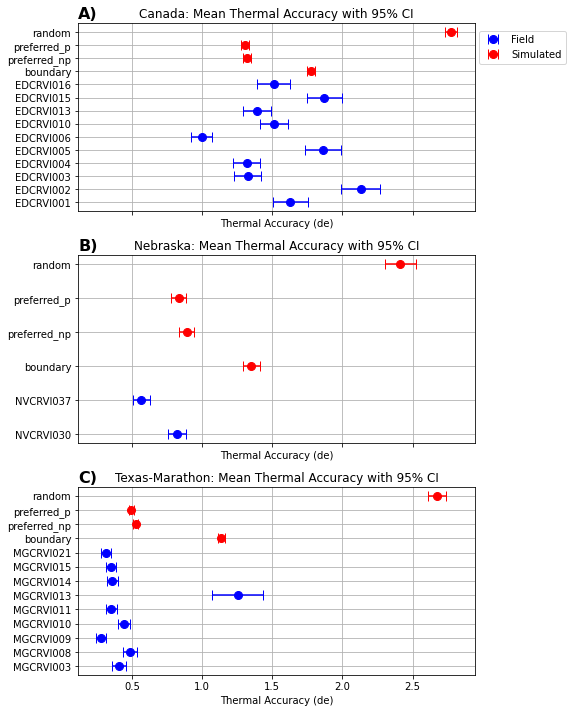

In [14]:
study_sites = df_combined['Study_Site'].unique()
num_sites = len(study_sites)

# Create a figure and axis grid
fig, axes = plt.subplots(nrows=num_sites, figsize=(8, 10), sharex=True)

# If there's only one study site, ensure axes is treated as a list
if num_sites == 1:
    axes = [axes]

# Define the subplot labels
labels = ['A)', 'B)', 'C)', 'D)']

# Define the list of simulated points to be colored red
simulated_snakes = ['random', 'boundary', 'preferred_np', 'preferred_p']

for i, site in enumerate(study_sites):
    site_data = df_combined[df_combined['Study_Site'] == site]

    # Split the data into simulated (red) and field (blue) based on the Snake_Name
    simulated_data = site_data[site_data['Snake_Name'].isin(simulated_snakes)]
    field_data = site_data[~site_data['Snake_Name'].isin(simulated_snakes)]

    # Plot field data (blue)
    axes[i].errorbar(field_data['mean_thermal_accuracy'], field_data['Snake_Name'], 
                     xerr=field_data['ci_thermal_accuracy'], fmt='o', capsize=5, markersize=8, color='b', label='Field')

    # Plot simulated data (red)
    axes[i].errorbar(simulated_data['mean_thermal_accuracy'], simulated_data['Snake_Name'], 
                     xerr=simulated_data['ci_thermal_accuracy'], fmt='o', capsize=5, markersize=8, color='r', label='Simulated')

    # Customize each subplot
    axes[i].set_title(f'{site}: Mean Thermal Accuracy with 95% CI')
    axes[i].set_xlabel('Thermal Accuracy (de)')
    axes[i].grid(True)

    # Add the subplot label outside the axes
    axes[i].text(0, 1.05, labels[i], transform=axes[i].transAxes, fontsize=16, fontweight='bold', va='center')

# Create a single legend for all subplots and place it outside the plot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.83, 0.93))

# Adjust layout to make space for the legend on the right
plt.tight_layout(rect=[0, 0, 0.85, 1])

if impute == 'no':
    plt.savefig('/home/mremington/Documents/therma_sim/ibutton_data_analysis/Figures/thermal_accuracy_1115.png')
else:
    plt.savefig('/home/mremington/Documents/therma_sim/ibutton_data_analysis/Figures/thermal_accuracy_imp_1115.png')
plt.show()

In [15]:
### De
env_df = train[['Date','Year', 'Month', 'Day','Minute', 'Study_Site', 'Burrow', 'Open',"random_thermal_quality_de", "boundary_thermal_quality_de", "preferred_np_thermal_quality_de",  'preferred_p_thermal_quality_de']]
#env_df = env_df.drop_duplicates()
#env_df[env_df['Study_Site'] == 'Texas-Marathon'].plot(x='Date', y='Burrow', kind='line', title='Temperature Data')
microhabitats = ['Burrow', 'Open']
sites = train['Study_Site'].unique()

results = []

# Loop through each site
for site in sites:
    condition1 = train['Study_Site'] == site
    temp_df = train.loc[condition1]

    # Extract the temperatures for the current microhabitat
    Tmod_burrow = temp_df['Burrow']
    Tmod_open = temp_df['Open']
    de_burrow = thermal_quality(Tmod=Tmod_burrow, Tset_min=t_pref_min, Tset_max=t_pref_max)
    de_open = thermal_quality(Tmod=Tmod_open, Tset_min=t_pref_min, Tset_max=t_pref_max)
    # Use .loc to avoid the SettingWithCopyWarning
    temp_df = temp_df.copy()  # Make a copy to avoid potential issues
    temp_df.loc[:, 'de_burrow'] = de_burrow
    temp_df.loc[:, 'de_open'] = de_open

    # Add the processed data to the results list
    results.append(temp_df[['Study_Site', 'Date', 'de_burrow', 'de_open',"random_thermal_quality_de", "boundary_thermal_quality_de", "preferred_np_thermal_quality_de",  'preferred_p_thermal_quality_de']])

# Concatenate all the DataFrame segments into one DataFrame
thermal_quality_df = pd.concat(results)
thermal_quality_df.head()


,Study_Site,Date,de_burrow,de_open,random_thermal_quality_de,boundary_thermal_quality_de,preferred_np_thermal_quality_de,preferred_p_thermal_quality_de
0,Canada,2022-07-07 23:00:01,0.00000,0.632,0.6319999999999979,0.6319999999999979,0.0,0.0
1,Canada,2022-07-08 00:10:01,0.00000,0.000,0.0,0.0,0.0,0.0
2,Canada,2022-07-08 01:20:01,0.00000,0.632,0.6319999999999979,0.6319999999999979,0.0,0.0
3,Canada,2022-07-08 02:30:01,0.13850,2.135,2.135,2.135,0.1385000000000005,0.1385000000000005
4,Canada,2022-07-08 03:40:01,1.01525,3.137,1.0152500000000018,1.0152500000000018,1.0152500000000018,1.0152500000000018


In [16]:
grouped_thermal_quality_df = thermal_quality_df.groupby('Study_Site').agg(
    mean_thermal_quality=('de_burrow', 'mean'),
    std_thermal_quality=('de_open', 'mean'),
    random_thermal_quality=('random_thermal_quality_de', 'mean'),
    boundary_thermal_quality=('boundary_thermal_quality_de', 'mean'),
    preferred_np_thermal_quality=('preferred_np_thermal_quality_de', 'mean'),
    preferred_p_thermal_quality=('preferred_p_thermal_quality_de', 'mean'),
)
grouped_thermal_quality_df.head(10)

,mean_thermal_quality,std_thermal_quality,random_thermal_quality,boundary_thermal_quality,preferred_np_thermal_quality,preferred_p_thermal_quality
Study_Site,,,,,,
Canada,1.587893,5.701261,3.642647,2.763043,1.874946,1.81431
Nebraska,1.031561,5.151006,3.096737,2.110641,1.310445,1.199852
Texas-Marathon,0.523682,6.137005,3.396311,1.959417,0.837738,0.771233


In [ ]:
# # Define the number of rows and columns for the grid
# num_sites = len(grouped.index)
# fig, axes = plt.subplots(nrows=num_sites, ncols=1, figsize=(10, 15), sharex=True)

# for idx, (site, ax) in enumerate(zip(grouped.index, axes)):
#     # Plot for de_burrow with confidence intervals and larger marker size
#     ax.errorbar(grouped.loc[site, 'mean_de_burrow'], 'Burrow', xerr=grouped.loc[site, 'ci_de_burrow'], fmt='o', capsize=5, markersize=10)
#     # Plot for de_open with confidence intervals and larger marker size
#     ax.errorbar(grouped.loc[site, 'mean_de_open'], 'Open', xerr=grouped.loc[site, 'ci_de_open'], fmt='o', capsize=5, markersize=10)
#     # Plot for random_thermal_quality_de with confidence intervals and larger marker size
#     ax.errorbar(grouped.loc[site, 'mean_random'], 'Random', xerr=grouped.loc[site, 'ci_random'], fmt='o', capsize=5, markersize=10)
#     # Plot for boundary_thermal_quality_de with confidence intervals and larger marker size
#     ax.errorbar(grouped.loc[site, 'mean_boundary'], 'Boundary', xerr=grouped.loc[site, 'ci_boundary'], fmt='o', capsize=5, markersize=10)
#     # Plot for preferred_np_thermal_quality_de with confidence intervals and larger marker size
#     ax.errorbar(grouped.loc[site, 'mean_preferred_np'], 'Preferred NP', xerr=grouped.loc[site, 'ci_preferred_np'], fmt='o', capsize=5, markersize=10)
#     # Plot for preferred_p_thermal_quality_de with confidence intervals and larger marker size
#     ax.errorbar(grouped.loc[site, 'mean_preferred_p'], 'Preferred P', xerr=grouped.loc[site, 'ci_preferred_p'], fmt='o', capsize=5, markersize=10)
    
#     # Set the y-axis to represent metric labels
#     ax.set_yticks([0, 1, 2, 3, 4, 5])
#     ax.set_yticklabels(['Burrow', 'Open', 'Random', 'Boundary', 'Preferred NP', 'Preferred P'])

#     # Title for each subplot representing the site
#     ax.set_title(f'Thermal Quality for Site: {site}')
    
#     # Invert y-axis to have metric labels at the y-axis
#     ax.invert_yaxis()
#     ax.grid(True)

# # Set common labels and adjust the layout
# plt.xlabel('Thermal Quality')

# fig.tight_layout()

# # Display the plots
# plt.show()

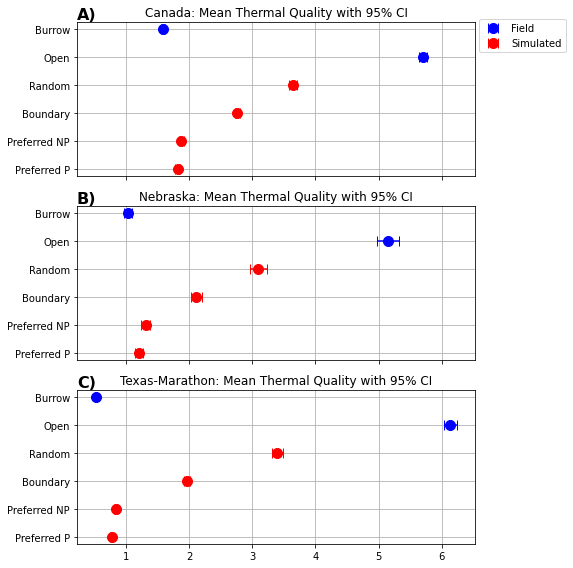

In [17]:
# Function to compute 95% confidence interval

# Assuming the thermal_quality_df already contains the additional columns
# Calculate the mean, std, and count (n) for confidence interval calculation
grouped = thermal_quality_df.groupby('Study_Site').agg(
    mean_de_burrow=('de_burrow', 'mean'),
    std_de_burrow=('de_burrow', 'std'),
    n_de_burrow=('de_burrow', 'count'),
    mean_de_open=('de_open', 'mean'),
    std_de_open=('de_open', 'std'),
    n_de_open=('de_open', 'count'),
    mean_random=('random_thermal_quality_de', 'mean'),
    std_random=('random_thermal_quality_de', 'std'),
    n_random=('random_thermal_quality_de', 'count'),
    mean_boundary=('boundary_thermal_quality_de', 'mean'),
    std_boundary=('boundary_thermal_quality_de', 'std'),
    n_boundary=('boundary_thermal_quality_de', 'count'),
    mean_preferred_np=('preferred_np_thermal_quality_de', 'mean'),
    std_preferred_np=('preferred_np_thermal_quality_de', 'std'),
    n_preferred_np=('preferred_np_thermal_quality_de', 'count'),
    mean_preferred_p=('preferred_p_thermal_quality_de', 'mean'),
    std_preferred_p=('preferred_p_thermal_quality_de', 'std'),
    n_preferred_p=('preferred_p_thermal_quality_de', 'count')
)

# Adding 95% confidence intervals to the grouped data
grouped['ci_de_burrow'] = compute_confidence_interval(grouped['mean_de_burrow'], grouped['std_de_burrow'], grouped['n_de_burrow'])
grouped['ci_de_open'] = compute_confidence_interval(grouped['mean_de_open'], grouped['std_de_open'], grouped['n_de_open'])
grouped['ci_random'] = compute_confidence_interval(grouped['mean_random'], grouped['std_random'], grouped['n_random'])
grouped['ci_boundary'] = compute_confidence_interval(grouped['mean_boundary'], grouped['std_boundary'], grouped['n_boundary'])
grouped['ci_preferred_np'] = compute_confidence_interval(grouped['mean_preferred_np'], grouped['std_preferred_np'], grouped['n_preferred_np'])
grouped['ci_preferred_p'] = compute_confidence_interval(grouped['mean_preferred_p'], grouped['std_preferred_p'], grouped['n_preferred_p'])

simulated_metrics = ['random', 'boundary', 'preferred_np', 'preferred_p']

num_sites = len(grouped.index)
fig, axes = plt.subplots(nrows=num_sites, ncols=1, figsize=(8, 8), sharex=True)

# Define the subplot labels
labels = ['A)', 'B)', 'C)', 'D)']

for idx, (site, ax) in enumerate(zip(grouped.index, axes)):
    # Plot for de_burrow (blue)
    ax.errorbar(grouped.loc[site, 'mean_de_burrow'], 'Burrow', xerr=grouped.loc[site, 'ci_de_burrow'], fmt='o', capsize=5, markersize=10, color='b', label='Field')
    
    # Plot for de_open (blue)
    ax.errorbar(grouped.loc[site, 'mean_de_open'], 'Open', xerr=grouped.loc[site, 'ci_de_open'], fmt='o', capsize=5, markersize=10, color='b', label='Field')

    # Plot for random_thermal_quality_de (red)
    ax.errorbar(grouped.loc[site, 'mean_random'], 'random', xerr=grouped.loc[site, 'ci_random'], fmt='o', capsize=5, markersize=10, color='r', label='Simulated')

    # Plot for boundary_thermal_quality_de (red)
    ax.errorbar(grouped.loc[site, 'mean_boundary'], 'boundary', xerr=grouped.loc[site, 'ci_boundary'], fmt='o', capsize=5, markersize=10, color='r', label='Simulated')

    # Plot for preferred_np_thermal_quality_de (red)
    ax.errorbar(grouped.loc[site, 'mean_preferred_np'], 'preferred_np', xerr=grouped.loc[site, 'ci_preferred_np'], fmt='o', capsize=5, markersize=10, color='r', label='Simulated')

    # Plot for preferred_p_thermal_quality_de (red)
    ax.errorbar(grouped.loc[site, 'mean_preferred_p'], 'preferred_p', xerr=grouped.loc[site, 'ci_preferred_p'], fmt='o', capsize=5, markersize=10, color='r', label='Simulated')
    
    # Set the y-axis to represent metric labels
    ax.set_yticks([0, 1, 2, 3, 4, 5])
    ax.set_yticklabels(['Burrow', 'Open', 'Random', 'Boundary', 'Preferred NP', 'Preferred P'])

    # Title for each subplot representing the site
    ax.set_title(f'{site}: Mean Thermal Quality with 95% CI')
    
    # Invert y-axis to have metric labels at the y-axis
    ax.invert_yaxis()
    ax.grid(True)
    
    # Add the subplot label outside the axes
    ax.text(0, 1.05, labels[idx], transform=ax.transAxes, fontsize=16, fontweight='bold', va='center')

# Create a single legend for all subplots and place it outside the plot
handles, labels = axes[0].get_legend_handles_labels()

# Filter out duplicate labels in the legend
by_label = dict(zip(labels, handles))

# Add the legend outside the plot area to the right
fig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(0.83, 0.93))

# Adjust layout to make space for the legend on the right
plt.tight_layout(rect=[0, 0, 0.85, 1]) 

# Save the figure if needed
if impute == 'no':
    plt.savefig('/home/mremington/Documents/therma_sim/ibutton_data_analysis/Figures/thermal_quality_1115.png')
else:
    plt.savefig('/home/mremington/Documents/therma_sim/ibutton_data_analysis/Figures/thermal_quality_imp_1115.png')

# Display the plots
plt.show()

In [ ]:
#############
##### DB ####
#############

In [ ]:
help(ax.legend)

In [ ]:
# Not Using
columns = ["random_thermal_effectivness_i",
           "boundary_thermal_effectivness_i",
           "preferred_np_thermal_effectivness_i",
           "preferred_p_thermal_effectivness_i"]
labels = ['Random', 'Boundary', 'Preferred', 'Preferred_est']
plt.figure(figsize=(10, 6))
for i, column in enumerate(columns):
    plt.plot(hourly_means.index, hourly_means[column], label=labels[i])

plt.xlabel('Hour of the day')
plt.ylabel('Mean Thermal Effectivnes')
plt.title('Thermal Effectivnes (i)')
plt.xticks(np.arange(0, 24, 1))
plt.legend()
plt.grid(True)
plt.show()

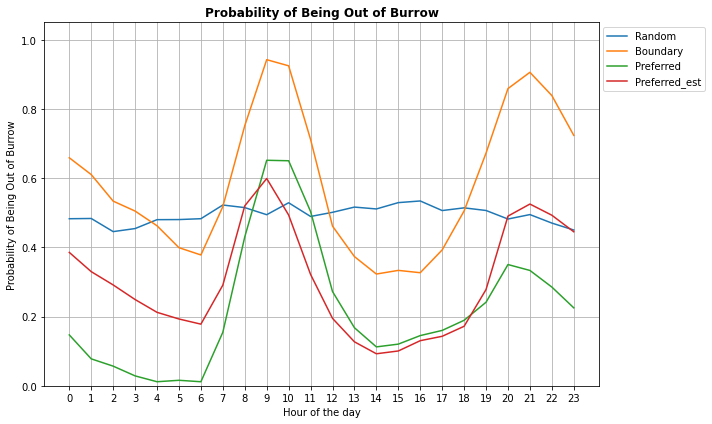

In [81]:
columns = ['Burrow_Usage_random', 'Burrow_Usage_bound', 'Burrow_Usage_np', 'Burrow_Usage_p']

labels = ['Random', 'Boundary', 'Preferred', 'Preferred_est']
plt.figure(figsize=(10, 6))
for i, column in enumerate(columns):
    plt.plot(hourly_means.index, hourly_means[column], label=labels[i])

plt.xlabel('Hour of the day')
plt.ylabel('Probability of Being Out of Burrow')
plt.title('Probability of Being Out of Burrow',fontweight='bold')
plt.xticks(np.arange(0, 24, 1))
plt.ylim(0,1.05)
plt.legend(loc='upper right', bbox_to_anchor=(1.2,1))
plt.grid(True)
plt.tight_layout()

if impute == 'no':
    plt.savefig('/home/mremington/Documents/therma_sim/ibutton_data_analysis/Figures/burrow_prob_hour.png',dpi=500)
else:
    plt.savefig('/home/mremington/Documents/therma_sim/ibutton_data_analysis/Figures/burrow_prob_hour_imp.png',dpi=500)
plt.show()